# Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 
___

Create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

# Summary
* [1. Data Information](#1.)
    * [1.1 Missing Values](#1.1)
    * [1.2 Numeric Features](#1.2)
    * [1.3 Categorical Features](#1.3)
* [2. Data Visualization](#2.)
    * [2.1 Owed Amount](#2.1)
    * [2.2 Agency Name](#2.2)
    * [2.3 Disposition](#2.3)
    * [2.4 Ticket Issued Month](#2.4)
    * [2.5 Ticket Issued Semester](#2.5)
    * [2.6 Hearing Month](#2.6)    
* [3. Compliance Predictive Model](#3.)
    * [3.1 Data Preprocessing and Feature Selection](#3.1)
    * [3.2 Models](#3.2)
    * [3.3 Hyperparameter Tuning](#3.3)
    * [3.4 Save Model](#3.4)
* [4. First Conclusion](#4.)
    * [4.1 Payment](#4.1)
    * [4.2 Compliance](#4.2)
    * [4.3 Model](#4.3)
    * [4.4 Next Steps](#4.4)
* [5. Payment Dataframe](#5.)
    * [5.1 Target Variable](#5.1)
* [6. Hypothesis](#6.)
    * [6.1 Hypothesis Creation](#6.1)
    * [6.2 Hypothesis Check](#6.2)
    * [6.3 Hypothesis Overview](#6.3)
* [7. Paid Predictive Model](#7.)
    * [7.1 Data Preprocessing](#7.1)
    * [7.2 Feature Selection](#7.2)
    * [7.3 Models](#7.3)
    * [7.4 Save Model](#7.4)

# Import the python libraries

In [103]:
# data analysis
import numpy as np
import pandas as pd
from scipy import stats

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# machine learning models
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# machine learning metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from boruta import BorutaPy
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, make_scorer

# other
import time
import joblib as jb
from pprint import pprint
import emoji
import pickle

# 1. Data information <a class='anchor' id='1.'></a>

In [5]:
# Remove the limit of columns to be displayed in the notebook
pd.set_option('display.max_columns', None)

In [6]:
df_train = pd.read_csv('csv/train.csv', encoding='ISO-8859-1', low_memory=False)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [7]:
df_train[(df_train['state'] == 'MI') & (df_train['city'].str.lower().str.startswith('det'))]['city'].unique()

array(['Detroit', 'DETROIT', 'Det', 'DEt', 'detroit', 'det', 'Det.',
       'DETRIT', 'DETOIT', 'detroitt', 'detriot', 'DETRIUT', 'DET',
       'DETROIT`', 'DETROTI', 'DETROITdetroit', 'DETROIOT', 'DETRJOIT',
       'DETROT', 'DETRPOT', 'DETRIOT', 'dETROIT', 'Detrofit', 'DETRROIT',
       'DETROIRT', 'DETROIT,', 'DETROITM', 'DETEROIT', 'Detroi',
       'Detroti', 'detrot', 'DETROITI', 'DETROIYT', 'Detroitf', 'det.',
       'DETROOIT', 'DETROIIT', 'DETORIT', 'detrorit', 'DETROIT1',
       'DETROITQ', 'Detrroit', 'DETEOIT', 'DETROIR', 'detrtoit',
       'Detriot', 'detroit`', 'DET.', 'deT', 'DETREOIT', 'DETAROIT',
       'DETTROIT', 'DETROIS', 'Detrot', 'DETROITT', 'Detro;it', 'DETRTOI',
       'DETROI', 'DEtroit', 'DETR4OIT', 'det48234', 'DET,', 'DETRIOIT',
       'Detorit', 'DETROPIT', 'DETROIT, MI. 48206', 'DETROUIT',
       'DETROIT, MI.', 'DETROKT', 'DETROITF', 'Detroir', 'DETOUR VILLAGE',
       'DETTROITM', 'DET ,', 'detoit', 'Detroit`', 'DET ROIT',
       'DET., MI.', 'DET.,', 'D

Analysing the unique cities from Michigan state that starts with 'det', the distinct city 'DETOUR VILLAGE' was identified.
<br>
First I removed all entries that are not from Detroit and the person was not fined (judgment_amount = 0)

In [8]:
df_train = df_train[(df_train['state'] == 'MI') & (df_train['city'].str.lower().str.startswith('det')) & (~df_train['city'].isin(['DETOUR VILLAGE'])) & (df_train['judgment_amount'] != 0)].set_index('ticket_id')
df_train['city'] = 'Detroit'

print(f'Number of Examples = {df_train.shape[0]}')
print(f'X Shape = {df_train.shape}')
print(f'y Shape = {df_train["compliance"].shape[0]}\n')

Number of Examples = 97584
X Shape = (97584, 33)
y Shape = 97584



## 1.1 Missing values <a class='anchor' id='1.1'></a>

In [9]:
print(f'Only features contained missing value in Training Dataset')
temp = df_train.isnull().sum()
print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Dataset
violator_name                    14
violation_zip_code            97584
mailing_address_str_number      715
non_us_str_code               97584
hearing_date                    116
payment_date                  74564
collection_status             77949
grafitti_status               97584
dtype: int64 



Drop the columns that most of rows are missing values, except for the payment_date column that may contain some useful information about the problem

In [10]:
null_features = df_train.isnull().sum()
all_null = df_train.columns[list(null_features == df_train.shape[0])]
df_train.drop(all_null, axis=1, inplace=True)
df_train.drop('collection_status', axis=1, inplace=True)

Drop the rows that has missing values for the remaining features, since they represent a really small portion of the dataset

In [11]:
null_features = df_train.isnull().sum()
null_2000 = df_train.columns[list((null_features < 2000) & (null_features != 0))]
df_train.drop(df_train[df_train[null_2000].isnull().any(axis=1)].index, inplace=True)

In [12]:
print(f'Only features contained missing value in Training Dataset')
temp = df_train.isnull().sum()
print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Dataset
payment_date    73935
dtype: int64 



In [13]:
print(f'Number of Examples = {df_train.shape[0]}')
print(f'X Shape = {df_train.shape}')
print(f'y Shape = {df_train["compliance"].shape[0]}\n')

Number of Examples = 96745
X Shape = (96745, 29)
y Shape = 96745



839 entries were removed from the training dataset<br>

## 1.2 Numeric Features <a class='anchor' id='1.2'></a>

In [14]:
df_train.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,9.674500e+04,9.674500e+04,96745.000000,96745.0,96745.0,96745.000000,96745.000000,96745.0,96745.000000,96745.000000,96745.000000,96745.000000
mean,1.031852e+04,7.865159e+03,324.110962,20.0,10.0,30.609737,0.139418,0.0,384.720699,57.096167,327.485197,0.069668
std,4.626965e+04,2.284441e+04,601.721250,0.0,0.0,60.407631,2.659109,0.0,661.510687,163.511476,666.774246,0.254587
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000
25%,4.314000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,230.000000,0.000000,85.000000,0.000000
50%,9.534000e+03,2.668000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
75%,1.542500e+04,1.354800e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000


In [15]:
print('There are {} numeric features in the training dataset'.format(len(df_train.describe().columns)))

There are 12 numeric features in the training dataset


In [16]:
df_train[df_train['discount_amount'] != 0][['discount_amount', 'judgment_amount', 'payment_amount', 'balance_due']].head()

,discount_amount,judgment_amount,payment_amount,balance_due
ticket_id,,,,
18653,25.0,280.0,255.0,0.0
18915,25.0,280.0,250.0,5.0
20851,30.0,330.0,260.0,40.0
22450,25.0,280.0,280.0,-25.0
22634,10.0,130.0,120.0,0.0


### Observations

* The 'judgment_amount' column does not include the value from the 'discount_amount' column
* We'll create a new column 'owed_amount' to get the result from the substraction of the 'judgment_amount' by the 'discount_amount'
* The 'mailing_address_str_number' and 'violation_street_number' columns are numeric categorical features

### Correlation hypothesis
* The 'compliance' may be related to the 'owed_amount' by the person

In [17]:
df_train['owed_amount'] = df_train['judgment_amount'] - df_train['discount_amount']
df_train[df_train['discount_amount'] != 0][['discount_amount', 'judgment_amount', 'owed_amount', 'payment_amount', 'balance_due']].head()

,discount_amount,judgment_amount,owed_amount,payment_amount,balance_due
ticket_id,,,,,
18653,25.0,280.0,255.0,255.0,0.0
18915,25.0,280.0,255.0,250.0,5.0
20851,30.0,330.0,300.0,260.0,40.0
22450,25.0,280.0,255.0,280.0,-25.0
22634,10.0,130.0,120.0,120.0,0.0


In [18]:
df_train.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance,owed_amount
count,9.674500e+04,9.674500e+04,96745.000000,96745.0,96745.0,96745.000000,96745.000000,96745.0,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000
mean,1.031852e+04,7.865159e+03,324.110962,20.0,10.0,30.609737,0.139418,0.0,384.720699,57.096167,327.485197,0.069668,384.581281
std,4.626965e+04,2.284441e+04,601.721250,0.0,0.0,60.407631,2.659109,0.0,661.510687,163.511476,666.774246,0.254587,661.483612
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000,52.000000
25%,4.314000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,230.000000,0.000000,85.000000,0.000000,230.000000
50%,9.534000e+03,2.668000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000
75%,1.542500e+04,1.354800e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000,11030.000000


Since the mean value of the owed_amount column is 268.6, 75% of the values are lower than 305 and the standard deviation is 626.8, we can infer that there are a lot of outliers in this column.

In [19]:
bands_dict = {}
band_columns = ['owed_amount']
for column in band_columns:
    band_name = column + '_band'
    if column == 'owed_amount':
        df_train[band_name] = pd.cut(df_train[column].drop(df_train[df_train[column] > 400].index), 5)
    else:
        df_train[band_name] = pd.cut(df_train[column], 5)
    bands = df_train.groupby(band_name).agg({'compliance':len})
    bands_dict[column] = bands
    df_train[band_name] = df_train[band_name].astype(str)
    for number, band in enumerate(bands.index):
        bands_dict[column].iloc[number] = number
        df_train.loc[df_train[band_name] == str(band), band_name] = number
    if column == 'owed_amount':
        df_train[band_name] = df_train[band_name].replace('nan', 4)
    df_train[band_name] = df_train[band_name].astype(int)

df_train.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,compliance_detail,compliance,owed_amount,owed_amount_band
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,MI,48208,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,compliant by late payment within 1 month,1.0,855.0,4
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1
18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:25:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1
28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",15307.0,SEVEN MILE,1537.0,E. Seven Mile,Detroit,MI,48205,USA,2004-07-12 13:30:00,2005-05-31 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4
18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",9100.0,VAN DYKE,91.0,Van Dyke,Detroit,MI,48213,USA,2004-07-28 12:15:00,2005-02-22 15:00:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4


## 1.3 Categorical Features <a class='anchor' id='1.3'></a>

In [20]:
df_train.describe(include=['O'])

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,payment_date,payment_status,compliance_detail
count,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,22810,96745,96745
unique,4,156,54958,1626,8258,1,1,493,1,49309,5667,166,182,3,2164,3,6
top,"Buildings, Safety Engineering & Env Department","Morris, John","APARTMENTS, CARLTON",SEVEN MILE,PO BOX,Detroit,MI,48227,USA,2008-01-22 09:00:00,2005-12-20 09:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,2007-05-25 00:00:00,NO PAYMENT APPLIED,non-compliant by no payment
freq,59860,8023,102,1570,1939,96745,96745,7219,96745,49,395,41242,41242,83817,93,73935,79062


### Observations
* The year and month from the 'ticket_issued_date' column can be extracted to build 2 new columns 'ticket_issued_year' and 'ticket_issued_month'
* The year and month from the 'hearing_date' can be extracted to build 2 new columns 'hearing_year' and 'hearing_month'
* The year and month from the 'payment_date' column can be extracted to build 2 new columns 'payment_year' and 'payment_month'

### Correlation hypothesis
* The 'compliance' may be related to the 'agency_name' that issued the ticket
* The 'compliance' may be related to the violation location ('violation_street_number' and 'violation_street_name' column can be used)
* The 'compliance' may be related to the violator's address ('mailing_address_str_number', 'mailing_address_str_name' and 'zip_code' columns can be used)
* The 'compliance' may be related to the 'ticket_issued_month' column
* The 'compliance' may be related to the 'hearing_month' column
* The 'compliance' may be related to the 'violation_code' column
* The 'compliance' may be related to the 'disposition' column

In [21]:
df_train = pd.concat([df_train, df_train['ticket_issued_date'].str.extract(r'(?P<ticket_issued_year>\d{4})-(?P<ticket_issued_month>\d{2})')], axis=1)
df_train['ticket_issued_semester'] = [1 if x <= 6 else 2 for x in df_train['ticket_issued_month'].astype(int)]
df_train = pd.concat([df_train, df_train['hearing_date'].str.extract(r'(?P<hearing_year>\d{4})-(?P<hearing_month>\d{2})')], axis=1)
df_train['hearing_semester'] = [1 if x <= 6 else 2 for x in df_train['hearing_month'].astype(int)]
df_train = pd.concat([df_train, df_train['payment_date'].str.extract(r'(?P<payment_year>\d{4})-(?P<payment_month>\d{2})')], axis=1)

In [22]:
df = df_train.copy()

In [23]:
df_train[['ticket_issued_date', 'ticket_issued_year', 'ticket_issued_month', 'ticket_issued_semester', 'hearing_date', 'hearing_year', 'hearing_month', 'payment_date', 'payment_year', 'payment_month']].head()

,ticket_issued_date,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_date,hearing_year,hearing_month,payment_date,payment_year,payment_month
ticket_id,,,,,,,,,,
27586,2004-04-23 12:30:00,2004,04,1,2005-05-06 13:30:00,2005,05,2005-06-02 00:00:00,2005,06
18735,2004-06-16 12:30:00,2004,06,1,2005-02-22 15:00:00,2005,02,NaN,NaN,NaN
18733,2004-06-16 12:25:00,2004,06,1,2005-02-22 15:00:00,2005,02,NaN,NaN,NaN
28204,2004-07-12 13:30:00,2004,07,2,2005-05-31 13:30:00,2005,05,NaN,NaN,NaN
18743,2004-07-28 12:15:00,2004,07,2,2005-02-22 15:00:00,2005,02,NaN,NaN,NaN


In [24]:
df_train[['agency_name', 'compliance']].groupby(['agency_name'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('agency_name').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
agency_name,
Detroit Police Department,12.05%
Department of Public Works,8.46%
"Buildings, Safety Engineering & Env Department",6.06%
Health Department,5.50%


Only consider violation_street_name that had 100 occurrences or more

In [25]:
df_train.loc[df_train.violation_street_name.isin(df_train[df_train['violation_street_name'].map(df_train['violation_street_name'].value_counts() < 100)]['violation_street_name'].value_counts().index), 'violation_street_name'] = 'Rare'
df_train[['violation_street_name', 'compliance']].groupby(['violation_street_name'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('violation_street_name').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
violation_street_name,
LAWTON,18.55%
MICHIGAN AVE,17.15%
SECOND,16.55%
GRATIOT,14.88%
MT ELLIOTT,14.50%
...,...
COLUMBUS,0.66%
LARNED,0.66%
LAKEVIEW,0.00%


Only consider violation_code that had 100 occurrences or more

In [26]:
df_train.loc[df_train.violation_code.isin(df_train[df_train['violation_code'].map(df_train['violation_code'].value_counts() < 100)]['violation_code'].value_counts().index), 'violation_code'] = 'Rare'
df_train[['violation_code', 'compliance']].groupby(['violation_code'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('violation_code').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
violation_code,
22-2-61,24.22%
61-81.0100/32.0066,15.96%
9-1-103(C),12.90%
22-2-43,12.44%
22-2-45,12.21%
9-1-110(a),11.90%
22-2-21(b),11.76%
9-1-209,11.68%
61-5-21,9.93%


Only consider zip_code that had 100 occurrences or more

In [27]:
df_train.loc[df_train.zip_code.isin(df_train[df_train['zip_code'].map(df_train['zip_code'].value_counts() < 100)]['zip_code'].value_counts().index), 'zip_code'] = 'Rare'
df_train[['zip_code', 'compliance']].groupby(['zip_code'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('zip_code').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
zip_code,
48216,14.51%
48209,11.84%
48237,10.91%
48201,10.23%
48226,9.41%
48207,9.28%
48236,8.92%
48239,8.79%
48212,8.53%


In [28]:
df_train[['disposition', 'compliance']].groupby(['disposition'], as_index=False).mean().sort_values(by='compliance', ascending=False).set_index('disposition').apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))

,compliance
disposition,
Responsible by Determination,29.05%
Responsible by Admission,28.90%
Responsible by Default,3.57%


We can analyse the data in order to be aware of the amount of compliant and non-compliant people in Detroit and understand how this problem is actually affecting the city

In [29]:
total_compliant_people = df_train[df_train['compliance'] == 1]['compliance'].value_counts().sum()
total_non_compliant_people = df_train[df_train['compliance'] == 0]['compliance'].value_counts().sum()
total_people = total_compliant_people + total_non_compliant_people
print('Percentage of compliant people: {:.2f}%'.format(total_compliant_people/total_people*100))
print('Percentage of non-compliant people: {:.2f}%'.format(total_non_compliant_people/total_people*100))

Percentage of compliant people: 6.97%
Percentage of non-compliant people: 93.03%


In [30]:
print('Total paid amount: ${0:,.2f}'.format(df_train['payment_amount'].sum()))

Total paid amount: $5,523,768.70


In [31]:
df_train.groupby('payment_year').agg({'payment_amount':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))

,payment_amount
payment_year,
2005,"$ 593,583.00"
2006,"$ 820,345.50"
2007,"$ 903,144.40"
2008,"$ 864,181.30"
2009,"$ 667,084.30"
2010,"$ 697,493.00"
2011,"$ 384,442.00"
2012,"$ 133,921.10"
2013,"$ 107,637.20"


We can see that the average payment amount per year decreased in the last years

In [32]:
df_train.groupby('payment_month').agg({'payment_amount':np.sum}).apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x))).sort_values(by='payment_amount', ascending=False)

,payment_amount
payment_month,
05,"$ 683,612.50"
06,"$ 666,660.60"
03,"$ 589,411.30"
04,"$ 498,545.40"
08,"$ 454,372.00"
10,"$ 428,112.60"
07,"$ 406,477.30"
09,"$ 405,066.90"
02,"$ 395,735.80"


* Months that contains the highest accumulated amounts of payment: March to June
* Months that contains the lowest accumulated amounts of payment: November to February
* Remainders or charges of late or possibly late tickets could be preferably be made from March to June

In [33]:
print('Total pending payment amount: ${0:,.2f}'.format(df_train['balance_due'].sum()))

Total pending payment amount: $31,682,555.40


In [34]:
ticket_issued_year_analysis = df_train.groupby('ticket_issued_year').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_year_analysis['paid_amount'] = ticket_issued_year_analysis['owed_amount'] - ticket_issued_year_analysis['balance_due']
ticket_issued_year_analysis['paid_percent'] = ticket_issued_year_analysis['paid_amount']/ticket_issued_year_analysis['owed_amount']
print('The average owed amount per year, since 2005, is $ {:,.2f}'.format(ticket_issued_year_analysis.iloc[2:]['owed_amount'].mean()))
print('The average pending payment amount per year, since 2005, is $ {:,.2f}'.format(ticket_issued_year_analysis.iloc[2:]['balance_due'].mean()))
print('The average payment percentage per year, since 2005, is {:.2f}%'.format(ticket_issued_year_analysis.iloc[2:]['paid_percent'].mean()*100))
currency_columns = ['owed_amount', 'balance_due', 'paid_amount']
percent_columns = ['compliance', 'paid_percent']
ticket_issued_year_analysis[currency_columns] = ticket_issued_year_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
ticket_issued_year_analysis[percent_columns] = ticket_issued_year_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
ticket_issued_year_analysis

The average owed amount per year, since 2005, is $ 5,314,118.71
The average pending payment amount per year, since 2005, is $ 4,525,170.77
The average payment percentage per year, since 2005, is 14.72%


,owed_amount,balance_due,compliance,paid_amount,paid_percent
ticket_issued_year,,,,,
1988,$ 85.00,$ 0.00,100.00%,$ 85.00,100.00%
2004,"$ 7,400.00","$ 6,360.00",25.00%,"$ 1,040.00",14.05%
2005,"$ 5,191,939.00","$ 3,934,927.60",7.61%,"$ 1,257,011.40",24.21%
2006,"$ 7,626,712.00","$ 6,406,304.30",7.23%,"$ 1,220,407.70",16.00%
2007,"$ 7,424,822.50","$ 6,583,295.40",7.07%,"$ 841,527.10",11.33%
2008,"$ 7,084,717.50","$ 6,125,964.90",6.49%,"$ 958,752.60",13.53%
2009,"$ 5,178,177.50","$ 4,524,650.90",7.37%,"$ 653,526.60",12.62%
2010,"$ 2,693,192.50","$ 2,361,414.20",4.56%,"$ 331,778.30",12.32%
2011,"$ 1,999,270.00","$ 1,739,638.10",7.92%,"$ 259,631.90",12.99%


In [35]:
ticket_issued_month_analysis = df_train.groupby('ticket_issued_month').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_month_analysis['paid_amount'] = ticket_issued_month_analysis['owed_amount'] - ticket_issued_month_analysis['balance_due']
ticket_issued_month_analysis['paid_percent'] = ticket_issued_month_analysis['paid_amount']/ticket_issued_month_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'paid_amount']
percent_columns = ['compliance', 'paid_percent']
ticket_issued_month_analysis[currency_columns] = ticket_issued_month_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
ticket_issued_month_analysis[percent_columns] = ticket_issued_month_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
ticket_issued_month_analysis

,owed_amount,balance_due,compliance,paid_amount,paid_percent
ticket_issued_month,,,,,
01,"$ 3,190,885.00","$ 2,675,823.20",8.84%,"$ 515,061.80",16.14%
02,"$ 3,204,078.50","$ 2,617,590.60",8.91%,"$ 586,487.90",18.30%
03,"$ 3,454,890.00","$ 2,820,192.50",9.24%,"$ 634,697.50",18.37%
04,"$ 3,394,797.50","$ 2,902,730.60",7.77%,"$ 492,066.90",14.49%
05,"$ 3,225,140.50","$ 2,775,016.90",7.56%,"$ 450,123.60",13.96%
06,"$ 3,105,892.50","$ 2,631,060.20",5.93%,"$ 474,832.30",15.29%
07,"$ 2,724,712.50","$ 2,309,026.60",5.77%,"$ 415,685.90",15.26%
08,"$ 3,377,980.00","$ 2,947,101.10",5.23%,"$ 430,878.90",12.76%
09,"$ 3,275,652.50","$ 2,820,800.00",5.67%,"$ 454,852.50",13.89%


In [36]:
ticket_issued_month_analysis = df_train.groupby('ticket_issued_month').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_month_analysis['ticket_issued_semester'] = np.where(ticket_issued_month_analysis.index.astype('int') <= 6, 1, 2)
ticket_issued_month_analysis = ticket_issued_month_analysis.groupby('ticket_issued_semester').agg({'owed_amount':np.sum, 'balance_due':np.sum, 'compliance':np.mean})
ticket_issued_month_analysis['paid_amount'] = ticket_issued_month_analysis['owed_amount'] - ticket_issued_month_analysis['balance_due']
ticket_issued_month_analysis['paid_percent'] = ticket_issued_month_analysis['paid_amount']/ticket_issued_month_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'paid_amount']
percent_columns = ['compliance', 'paid_percent']
ticket_issued_month_analysis[currency_columns] = ticket_issued_month_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
ticket_issued_month_analysis[percent_columns] = ticket_issued_month_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
ticket_issued_month_analysis

,owed_amount,balance_due,compliance,paid_amount,paid_percent
ticket_issued_semester,,,,,
1,"$ 19,575,684.00","$ 16,422,414.00",8.04%,"$ 3,153,270.00",16.11%
2,"$ 17,630,632.00","$ 15,260,141.40",5.95%,"$ 2,370,490.60",13.45%


* The payment_amount and compliance percentage is higher in tickets issued the first semester
* The city hall can be aware of this tendency and build some strategies to first improve the compliance of these tickets

In [37]:
df_train['compliance_detail'].value_counts()

non-compliant by no payment                        79062
non-compliant by late payment more than 1 month    10943
compliant by late payment within 1 month            3691
compliant by on-time payment                        2416
compliant by early payment                           587
compliant by payment on unknown date                  46
Name: compliance_detail, dtype: int64

In [38]:
df_train['compliance_detail'].value_counts(normalize=True).apply(lambda x: '{:.2f}%'.format(x*100))

non-compliant by no payment                        81.72%
non-compliant by late payment more than 1 month    11.31%
compliant by late payment within 1 month            3.82%
compliant by on-time payment                        2.50%
compliant by early payment                          0.61%
compliant by payment on unknown date                0.05%
Name: compliance_detail, dtype: object

In [39]:
df_train[df_train['compliance'] == 0]['compliance_detail'].value_counts(normalize=True).apply(lambda x: '{:.2f}%'.format(x*100))

non-compliant by no payment                        87.84%
non-compliant by late payment more than 1 month    12.16%
Name: compliance_detail, dtype: object

In [40]:
compliance_detail_analysis = df_train.groupby('compliance_detail').agg({'owed_amount':np.sum, 'payment_amount':np.sum, 'balance_due':np.sum})
compliance_detail_analysis['paid_percent'] = compliance_detail_analysis['payment_amount']/compliance_detail_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'payment_amount']
percent_columns = ['paid_percent']
compliance_detail_analysis[currency_columns] = compliance_detail_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
compliance_detail_analysis[percent_columns] = compliance_detail_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
compliance_detail_analysis

,owed_amount,payment_amount,balance_due,paid_percent
compliance_detail,,,,
compliant by early payment,"$ 130,867.00","$ 122,559.00","$ 8,316.00",93.65%
compliant by late payment within 1 month,"$ 1,003,852.00","$ 919,390.80","$ 84,461.20",91.59%
compliant by on-time payment,"$ 581,925.00","$ 581,885.00",$ 40.00,99.99%
compliant by payment on unknown date,"$ 15,577.50","$ 15,582.50",$ -5.00,100.03%
non-compliant by late payment more than 1 month,"$ 3,275,719.50","$ 2,896,593.80","$ 379,125.70",88.43%
non-compliant by no payment,"$ 32,198,375.00","$ 987,757.60","$ 31,210,617.50",3.07%


In [41]:
compliance_analysis = df_train.groupby('compliance').agg({'owed_amount':np.sum, 'payment_amount':np.sum, 'balance_due':np.sum})
compliance_analysis['paid_percent'] = compliance_analysis['payment_amount']/compliance_analysis['owed_amount']
currency_columns = ['owed_amount', 'balance_due', 'payment_amount']
percent_columns = ['paid_percent']
compliance_analysis[currency_columns] = compliance_analysis[currency_columns].apply(lambda series: series.apply(lambda x: '$ {0:,.2f}'.format(x)))
compliance_analysis[percent_columns] = compliance_analysis[percent_columns].apply(lambda series: series.apply(lambda x: '{:.2f}%'.format(x*100)))
compliance_analysis

,owed_amount,payment_amount,balance_due,paid_percent
compliance,,,,
0.0,"$ 35,474,094.50","$ 3,884,351.40","$ 31,589,743.20",10.95%
1.0,"$ 1,732,221.50","$ 1,639,417.30","$ 92,812.20",94.64%


* Almost 88% of the non-compliant cases are from people who didn't pay the blight ticket
* There is more than 31 million US dollars that are pending from payment of non-compliant people

# 2. Data Visualization <a class='anchor' id='2.'></a>

In [46]:
def add_value_labels(ax, orientation, xspace=0, yspace=0, percentage=False):
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        if orientation == 'v':
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            label = rect.get_height()
        elif orientation == 'h':
            y_value = rect.get_y() + rect.get_height() / 4
            x_value = rect.get_width()
            label = rect.get_width()            

        # Vertical alignment for positive values
        va = 'bottom'

        # Define the label format
        if percentage==True:
            label = "{:.1%}".format(label)
        else:
            label = "{:,.0f}".format(label)

        # Create annotation
        ax.annotate(
            label,                     
            (x_value, y_value),        
            xytext=(xspace, yspace),   
            textcoords="offset points",
            ha='center',               
            va=va)                     

In [47]:
def plot_percent_category(df, field, xvalues, compliance=False, xticks=None, legend_loc='best', xspace=0, yspace=0, legend_pos=None):
    total = []
    non_compliant = []
    compliant = []
    
    total_values = df[field].value_counts().sort_index()
    non_compliant_values = df[df['compliance'] == 0][field].value_counts()
    compliant_values = df[df['compliance'] == 1][field].value_counts()
    
    if xticks == None:
        xticks = xvalues
    
    for value in xvalues:
        if value in total_values.index:
            total.append(total_values[value])
        else:
            total.append(0)
            
        if value in non_compliant_values.index:
            non_compliant.append(non_compliant_values[value])
        else:
            non_compliant.append(0)
        
        if value in compliant_values.index:
            compliant.append(compliant_values[value])
        else:
            compliant.append(0)


    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    w = 1
    folds = np.linspace(5,len(xvalues)*5, len(xvalues))
    
    if compliance == False:
        image = 'images/' + field + '_Bar'
        title = 'Customer percentage distribution by {} and compliance'.format(field)
        ax.bar([element - w/2 for element in folds], [number if sum(total) == 0 else number / sum(total) for number in non_compliant], width=w)
        ax.bar([element + w/2 for element in folds], [number if sum(total) == 0 else number / sum(total) for number in compliant], width=w)
    else:
        image = 'images/' + field + '_Bar_Compliance'
        title = 'Compliance percentage by {}'.format(field)
        ax.bar([element - w/2 for element in folds], [number if total == 0 else number / total for number, total in zip(non_compliant, total)], width=w)
        ax.bar([element + w/2 for element in folds], [number if total == 0 else number / total for number, total in zip(compliant, total)], width=w)
        
    add_value_labels(ax, orientation='v', yspace=5, percentage=True, xspace=xspace)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.xticks(folds, xticks)
    plt.title(title, fontweight='bold',size=15)
    legend = ['Non-compliant', 'Compliant']
    if legend_pos == None:
        plt.legend(legend, framealpha=0, loc=legend_loc)
    else:
        plt.legend(legend, framealpha=0, bbox_to_anchor=legend_pos)
    #plt.savefig(image)
    plt.show()

In [48]:
def plot_pie(df, field, legend, compliance=False, order=None, size=(16,8), pct=0.75, startangle=0, legend_pos=(0.2,0.2), pct_pos={}):
    # Define if only the respondent customers will be considered
    if compliance == False:
        image = 'images/' + field + '_Pie'
        entries = df[field].value_counts()
        title = 'Customers percentage distribution by {}'.format(field)
    else:
        image = 'images/' + field + '_Pie_Compliance'
        entries = df[df['compliance'] == 1][field].value_counts()
        title = 'Compliant customers percentage distribution by {}'.format(field)
    
    legend_copy = legend.copy()
    
    # Define if there is an exact order of values to be plotted
    if order == None:
        compliant = list(entries)
    else:
        compliant = []
        for value in order[::-1]:
            if value in entries.index:
                compliant.append(entries[value])
            else:
                legend_copy.pop(value)
        compliant = compliant[::-1]
    
    # Set the figure parameters
    sns.set(style='white',font_scale=1.1, rc={'figure.figsize':size})

    # Create pie chart
    ax = plt.subplot(1, 2, 1)
    plt.title(title, fontweight='bold',size=15)
    _, _, autopcts = ax.pie(compliant, autopct='%1.1f%%', pctdistance=pct, startangle=startangle)
    plt.setp(autopcts, **{'fontsize':15, 'fontweight': 'bold'})
    
    # Adjust pct positions
    for key, value in pct_pos.items():
        pct = autopcts[key]
        d=1
        xi,yi = pct.get_position()
        ri = np.sqrt(xi**2+yi**2)
        phi = np.arctan2(yi,xi)
        x = d*ri*np.cos(phi)+value[0]
        y = d*ri*np.sin(phi)+value[1]
        pct.set_position((x,y))

    plt.legend(legend_copy, bbox_to_anchor=legend_pos, framealpha=0.0, prop={'size': 12})
    #plt.savefig(image)
    plt.show()

## 2.1 Owed Amount <a class='anchor' id='2.1'></a>

Bar plot with interval percentages

In [49]:
bands_dict['owed_amount']

,compliance
owed_amount_band,
"(51.692, 113.6]",0.0
"(113.6, 175.2]",1.0
"(175.2, 236.8]",2.0
"(236.8, 298.4]",3.0
"(298.4, 360.0]",4.0


In [50]:
df_train['owed_amount_band'].value_counts().sort_index()

0    12678
1    10878
2      728
3    10828
4    61633
Name: owed_amount_band, dtype: int64

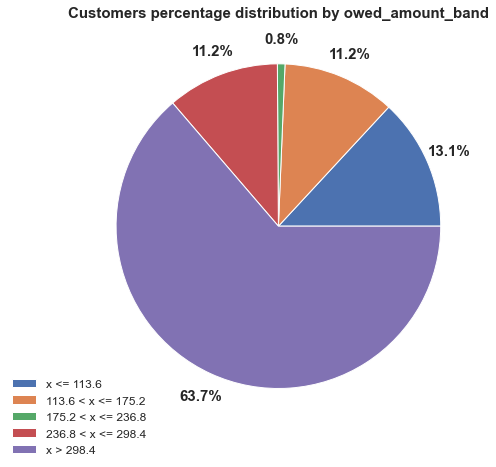

In [51]:
owed_amount_ticks = ['x <= 113.6', '113.6 < x <= 175.2', '175.2 < x <= 236.8', '236.8 < x <= 298.4', 'x > 298.4']
order = list(np.linspace(0,4,5))
plot_pie(df_train, 'owed_amount_band', owed_amount_ticks, order=order, pct=1.15, legend_pos=(0.2,0.15))

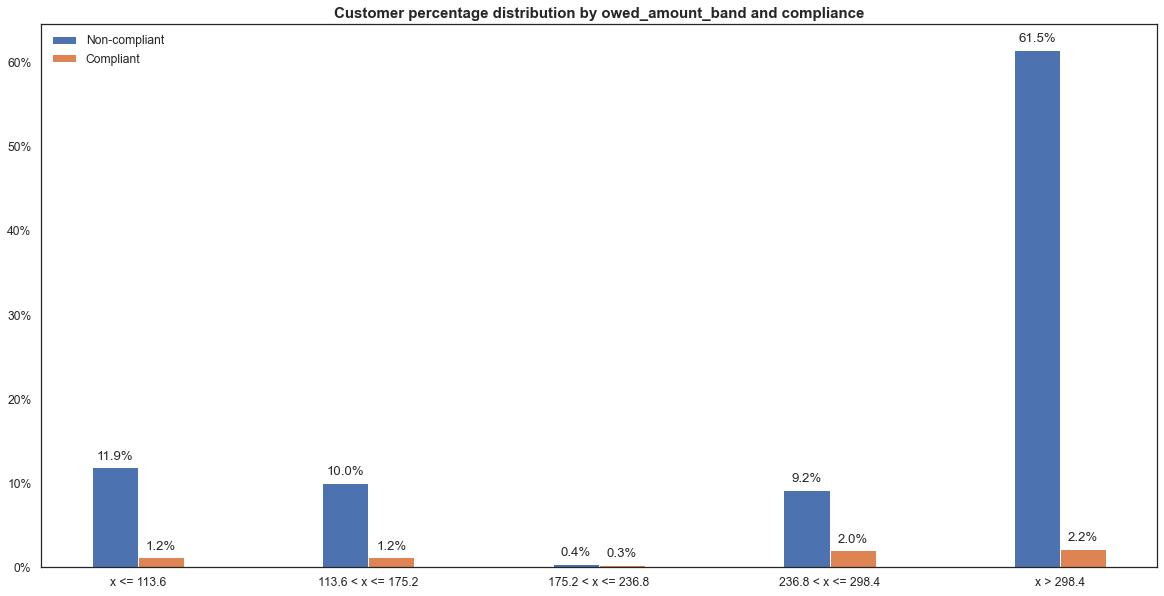

In [52]:
plot_percent_category(df_train, 'owed_amount_band', order, xticks=owed_amount_ticks)

In [53]:
df_train[df_train['compliance'] == 1]['owed_amount_band'].value_counts().sort_index()

0    1164
1    1160
2     321
3    1944
4    2151
Name: owed_amount_band, dtype: int64

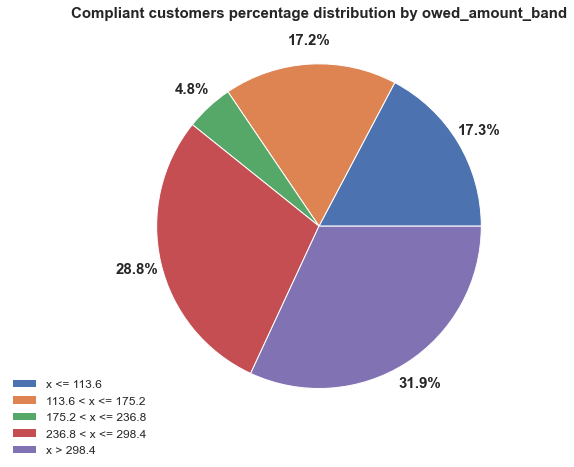

In [54]:
plot_pie(df_train, 'owed_amount_band', owed_amount_ticks, compliance=True, order=order, pct=1.15, legend_pos=(0.1,0.15))

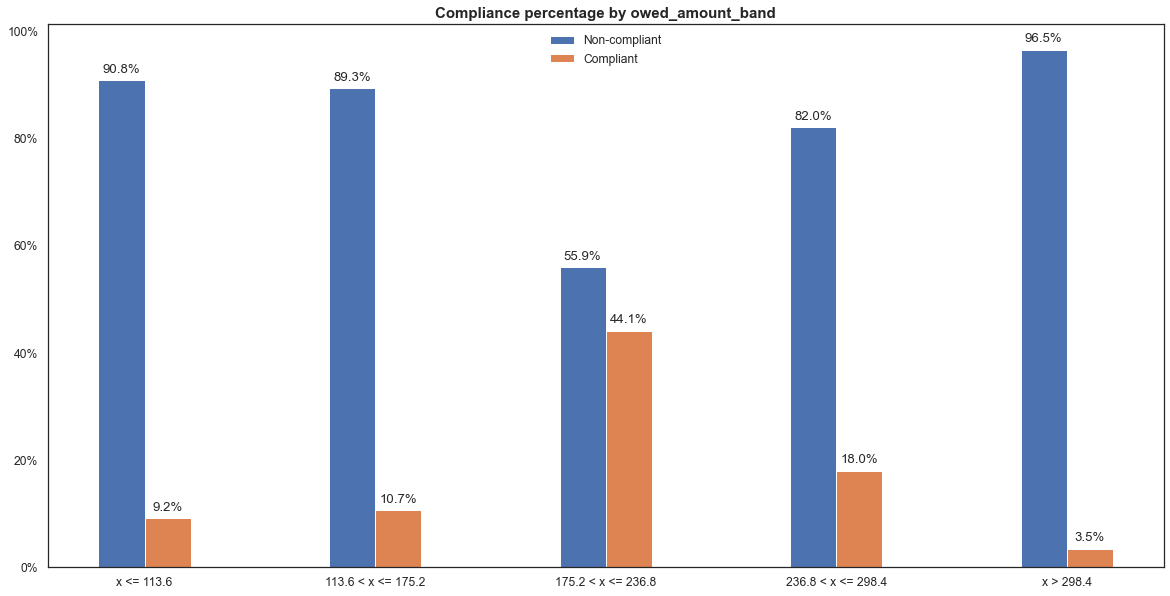

In [55]:
plot_percent_category(df_train, 'owed_amount_band', order, xticks=owed_amount_ticks, compliance=True, legend_loc=9)

### Observations:
* It seems that people that owes an amount between 175.2 and 236.8 have a higher compliance ratio, but it corresponds to only 0.8% of all issued people

## 2.2 Agency Name <a class='anchor' id='2.2'></a>

In [56]:
df_train['agency_name'].value_counts().sort_index().index

Index(['Buildings, Safety Engineering & Env Department',
       'Department of Public Works', 'Detroit Police Department',
       'Health Department'],
      dtype='object')

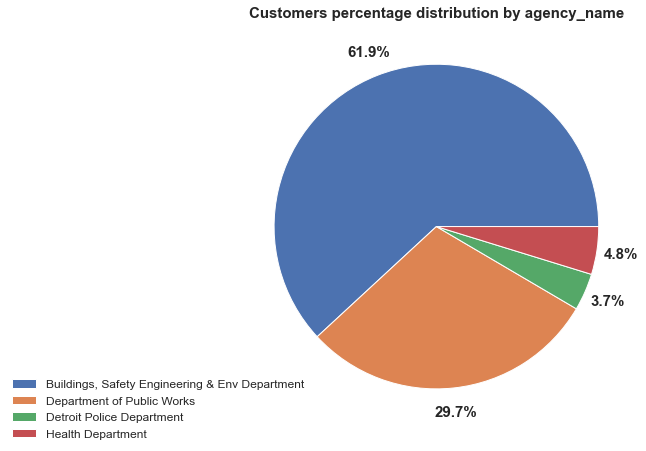

In [57]:
agency_ticks = list(df_train['agency_name'].value_counts().sort_index().index)
plot_pie(df_train, 'agency_name', agency_ticks, order=agency_ticks, pct=1.15, legend_pos=(0.2,0.15))

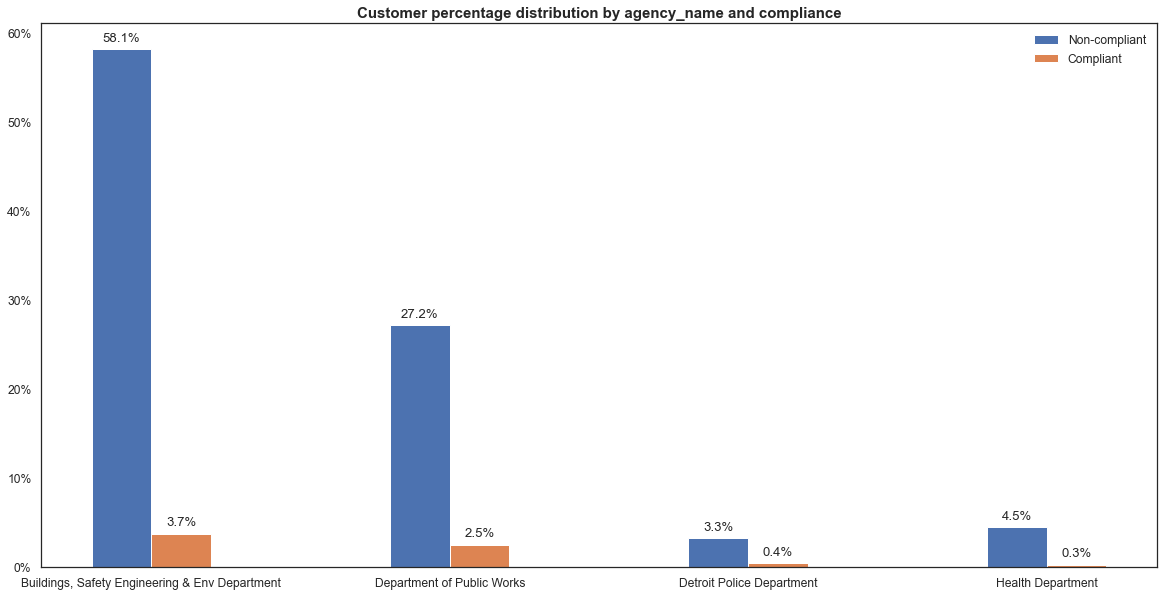

In [58]:
plot_percent_category(df_train, 'agency_name', agency_ticks, xticks=agency_ticks)

In [59]:
df_train[df_train['compliance'] == 1]['agency_name'].value_counts().sort_index()

Buildings, Safety Engineering & Env Department    3627
Department of Public Works                        2429
Detroit Police Department                          431
Health Department                                  253
Name: agency_name, dtype: int64

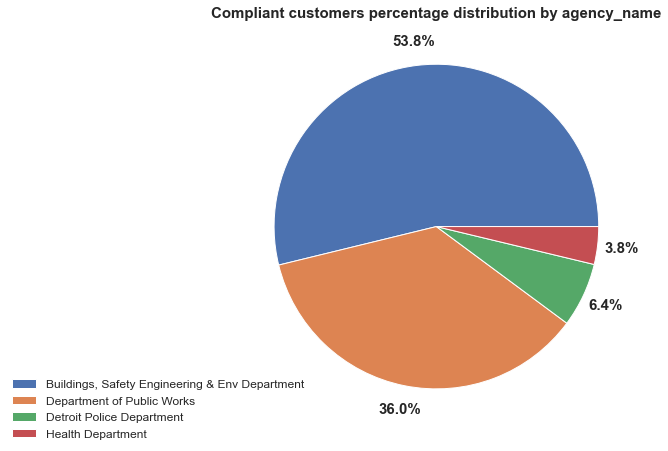

In [60]:
plot_pie(df_train, 'agency_name', agency_ticks, compliance=True, order=agency_ticks, pct=1.15, legend_pos=(0.2,0.15))

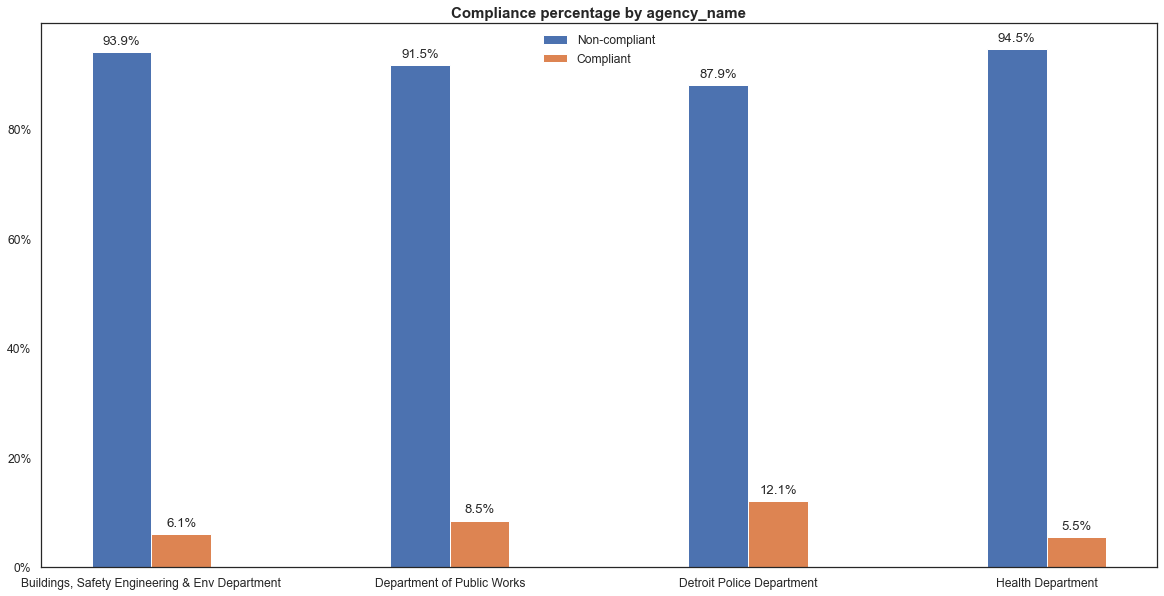

In [61]:
plot_percent_category(df_train, 'agency_name', agency_ticks, xticks=agency_ticks, compliance=True, legend_loc=9)

### Observations:
* Tickets issued by the Detroit Police Department have higher compliance ratio

## 2.3 Disposition <a class='anchor' id='2.3'></a>

In [62]:
df_train['disposition'].value_counts()

Responsible by Default          83817
Responsible by Admission         7758
Responsible by Determination     5170
Name: disposition, dtype: int64

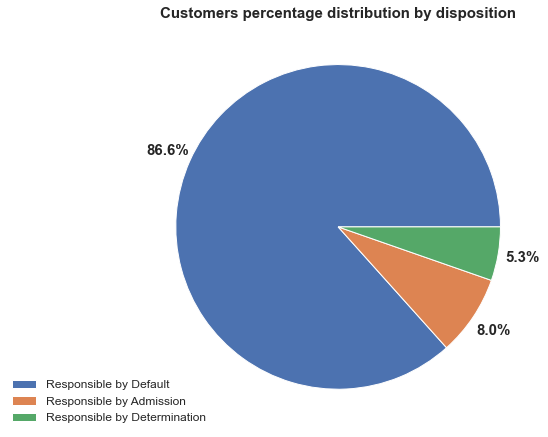

In [63]:
disposition_ticks = list(df_train['disposition'].value_counts().index)
plot_pie(df_train, 'disposition', disposition_ticks, order=disposition_ticks, pct=1.15, legend_pos=(0.2,0.15))

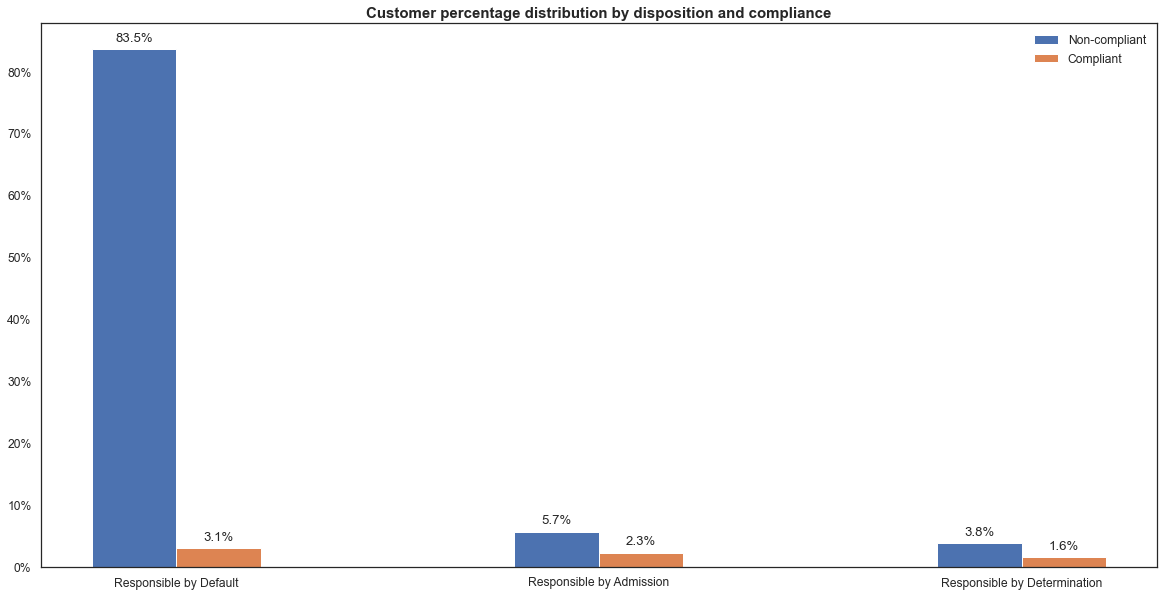

In [64]:
plot_percent_category(df_train, 'disposition', disposition_ticks, xticks=disposition_ticks)

In [65]:
df_train[df_train['compliance'] == 1]['disposition'].value_counts().sort_index()

Responsible by Admission        2242
Responsible by Default          2996
Responsible by Determination    1502
Name: disposition, dtype: int64

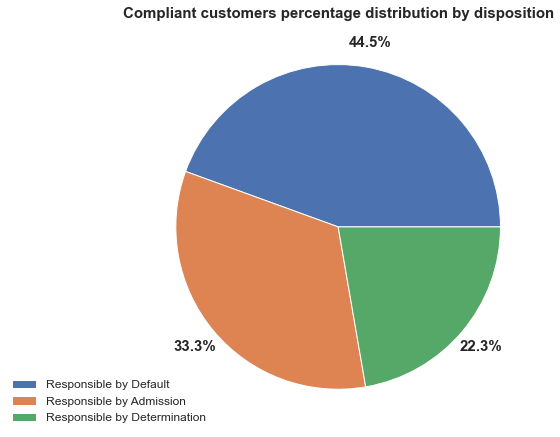

In [66]:
plot_pie(df_train, 'disposition', disposition_ticks, compliance=True, order=disposition_ticks, pct=1.15, legend_pos=(0.2,0.15))

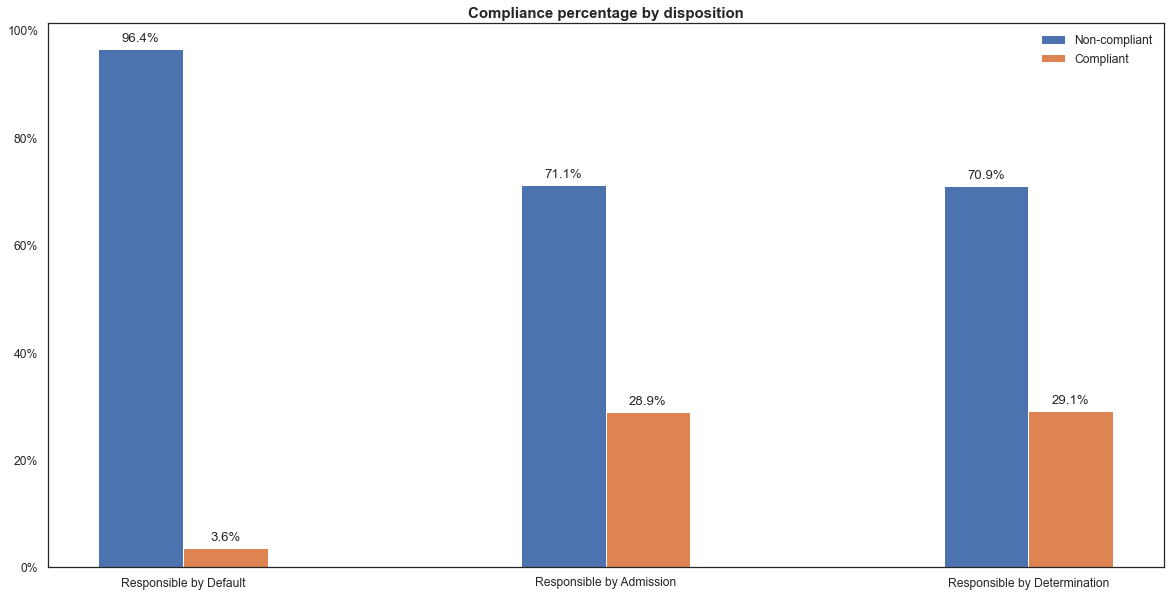

In [67]:
plot_percent_category(df_train, 'disposition', disposition_ticks, xticks=disposition_ticks, compliance=True)

### Observations:
* People that are judged as Responsible by Default have lower compliance ratio than the other types, but 86.6% percent of all tickets are issued in this type

## 2.4 Ticket Issued Month <a class='anchor' id='2.4'></a>

In [68]:
df_train['ticket_issued_month'].value_counts().sort_index()

01    7900
02    8732
03    9207
04    7744
05    8149
06    8419
07    7785
08    8857
09    9329
10    9267
11    6234
12    5122
Name: ticket_issued_month, dtype: int64

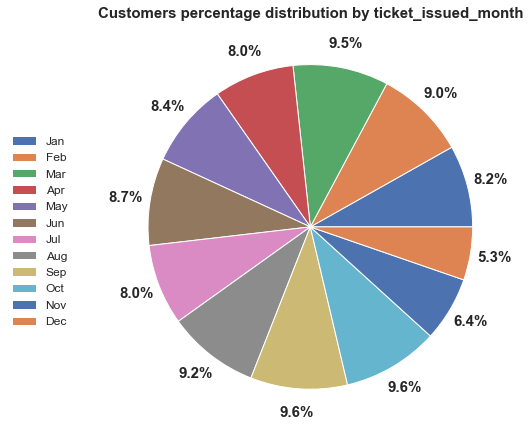

In [69]:
month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
order = list(df_train['ticket_issued_month'].value_counts().sort_index().index)
plot_pie(df_train, 'ticket_issued_month', month_ticks, order=order, pct=1.15, legend_pos=(-0.07,0.75))

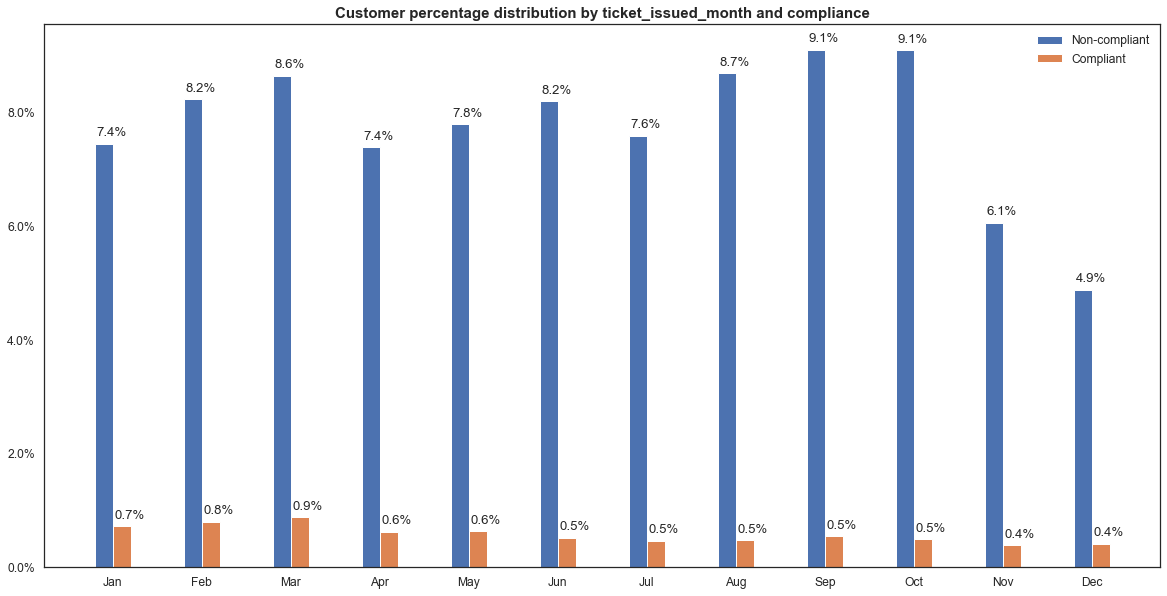

In [70]:
plot_percent_category(df_train, 'ticket_issued_month', order, xticks=month_ticks, xspace=8)

In [71]:
df_train[df_train['compliance'] == 1]['ticket_issued_month'].value_counts().sort_index()

01    698
02    778
03    851
04    602
05    616
06    499
07    449
08    463
09    529
10    477
11    377
12    401
Name: ticket_issued_month, dtype: int64

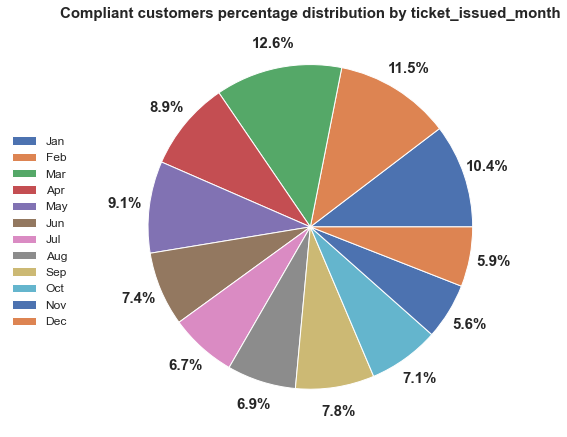

In [72]:
plot_pie(df_train, 'ticket_issued_month', month_ticks, compliance=True, order=order, pct=1.15, legend_pos=(-0.07,0.75))

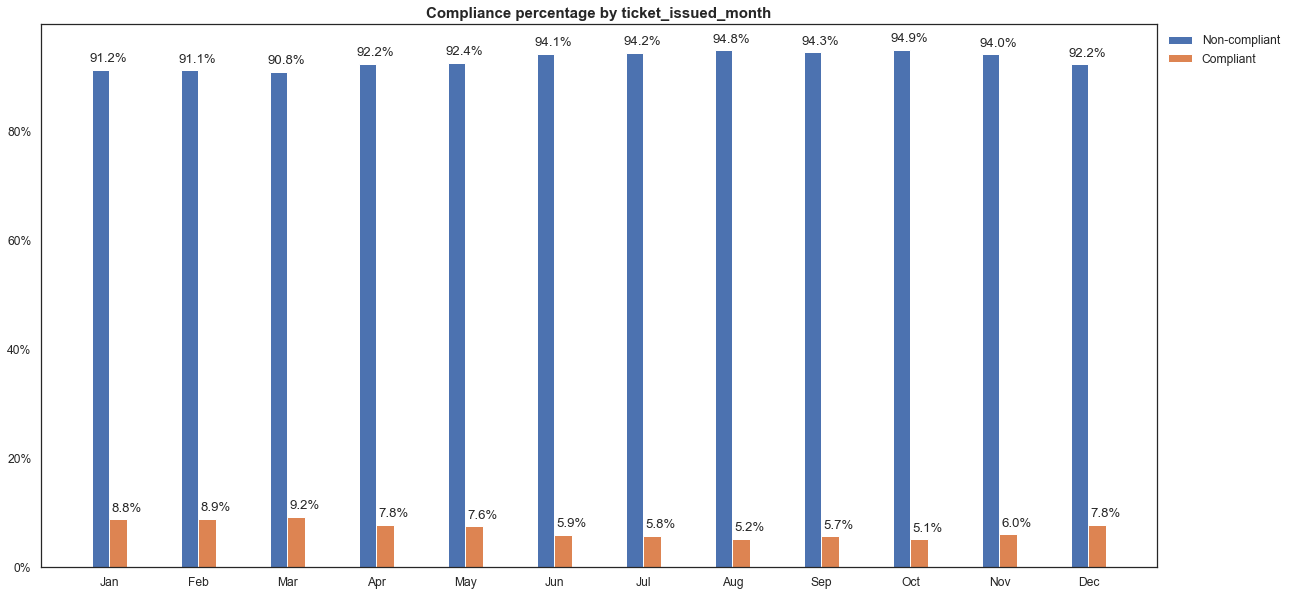

In [73]:
plot_percent_category(df_train, 'ticket_issued_month', order, xticks=month_ticks, compliance=True, xspace=8, legend_pos=(1,1))

### Observations:
* It looks like there is an average compliance ratio in months from the first semester than the second one

## 2.5 Ticket Issued Semester <a class='anchor' id='2.5'></a>

In [74]:
df_train['ticket_issued_semester'].value_counts()

1    50151
2    46594
Name: ticket_issued_semester, dtype: int64

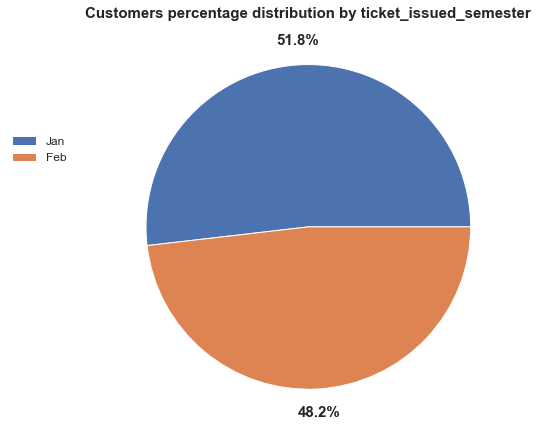

In [75]:
order = list(df_train['ticket_issued_semester'].value_counts().sort_index().index)
plot_pie(df_train, 'ticket_issued_semester', month_ticks, order=order, pct=1.15, legend_pos=(-0.07,0.75))

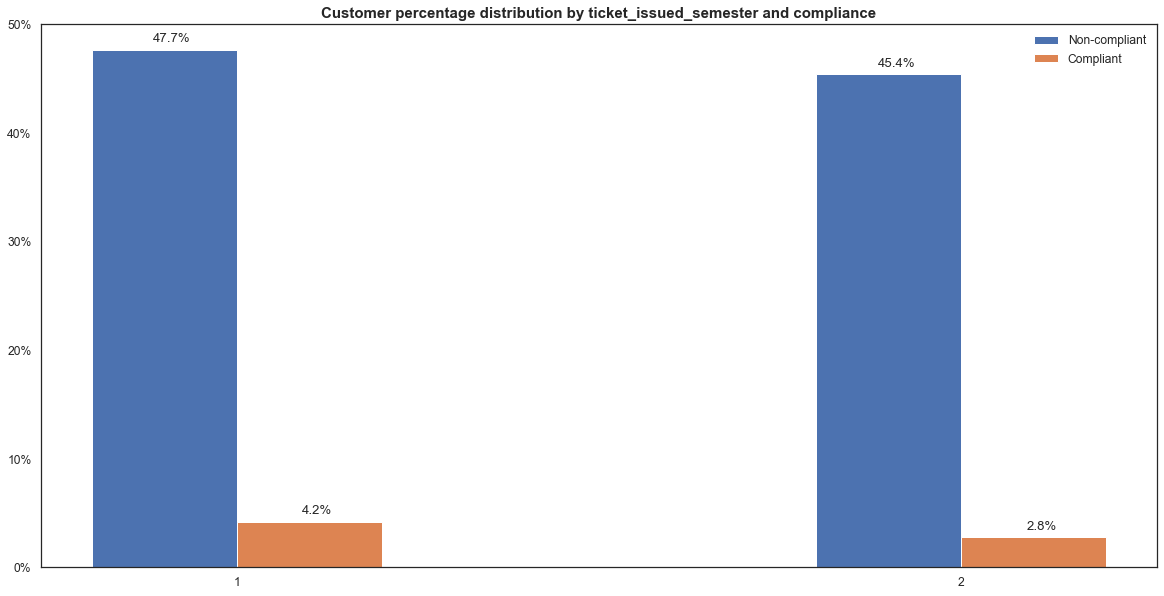

In [76]:
plot_percent_category(df_train, 'ticket_issued_semester', order, xticks=order, xspace=8)

In [77]:
df_train[df_train['compliance'] == 1]['ticket_issued_semester'].value_counts().sort_index()

1    4044
2    2696
Name: ticket_issued_semester, dtype: int64

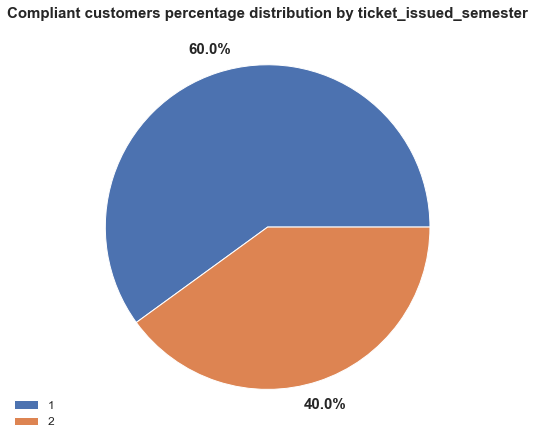

In [78]:
plot_pie(df_train, 'ticket_issued_semester', order, compliance=True, order=order, pct=1.15, legend_pos=(0,0.1))

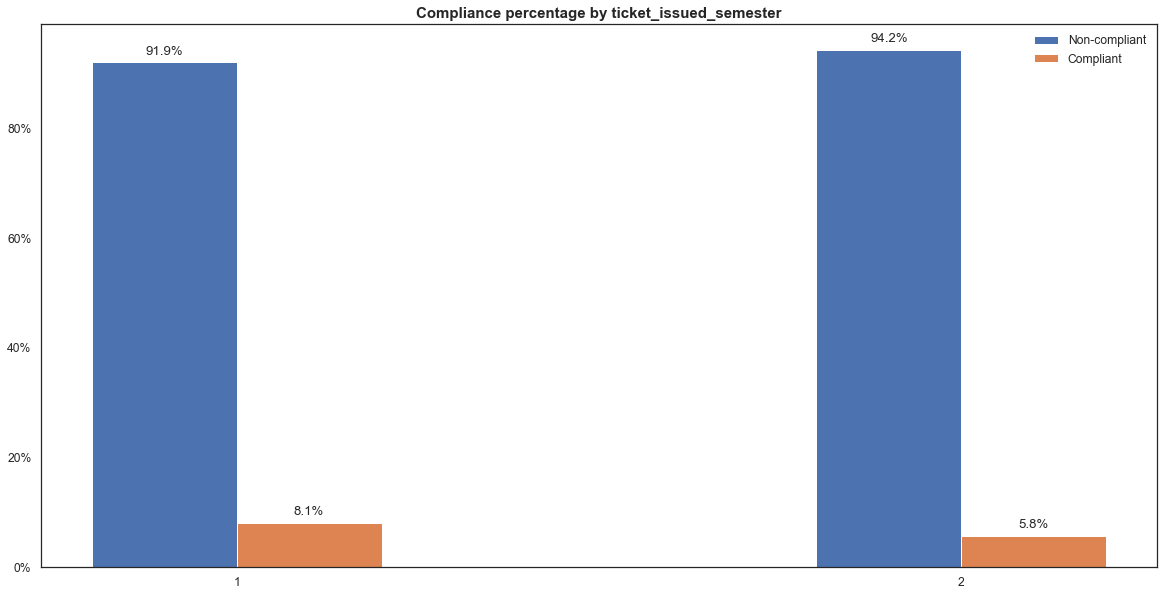

In [79]:
plot_percent_category(df_train, 'ticket_issued_semester', order, xticks=order, compliance=True)

### Observations:
* The average compliance ratio is higher in tickets issued in the first semester of the year

## 2.6 Hearing Month <a class='anchor' id='2.6'></a>

In [80]:
df_train['hearing_month'].value_counts().sort_index()

01     5388
02     6689
03     9312
04    11927
05     8580
06     7449
07     7369
08     8254
09     6856
10     8447
11     6961
12     9513
Name: hearing_month, dtype: int64

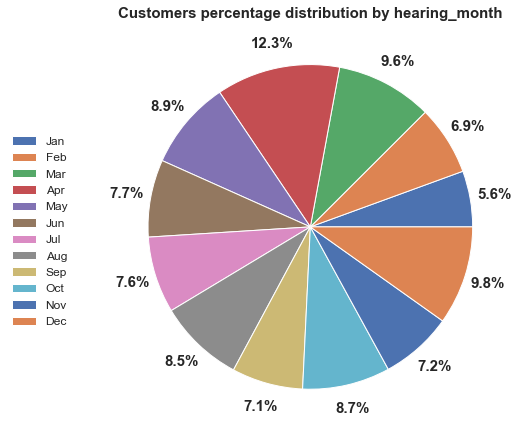

In [81]:
month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
order = list(df_train['hearing_month'].value_counts().sort_index().index)
plot_pie(df_train, 'hearing_month', month_ticks, order=order, pct=1.15, legend_pos=(-0.07,0.75))

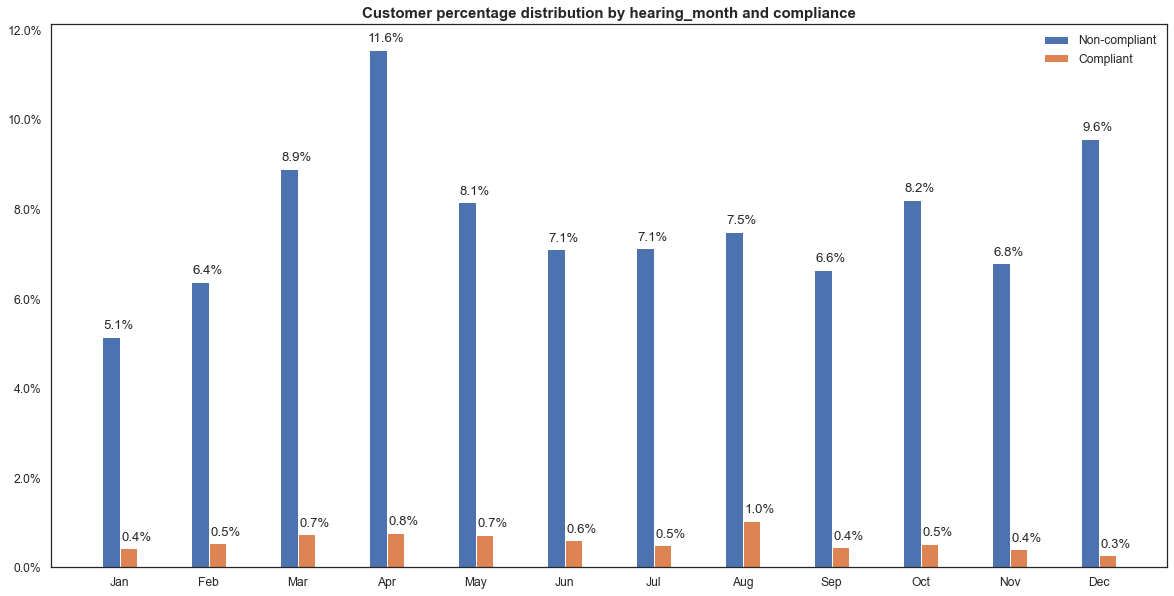

In [82]:
plot_percent_category(df_train, 'hearing_month', order, xticks=month_ticks, xspace=8)

In [83]:
df_train[df_train['compliance'] == 1]['hearing_month'].value_counts().sort_index()

01     407
02     522
03     709
04     746
05     698
06     580
07     477
08    1010
09     432
10     511
11     393
12     255
Name: hearing_month, dtype: int64

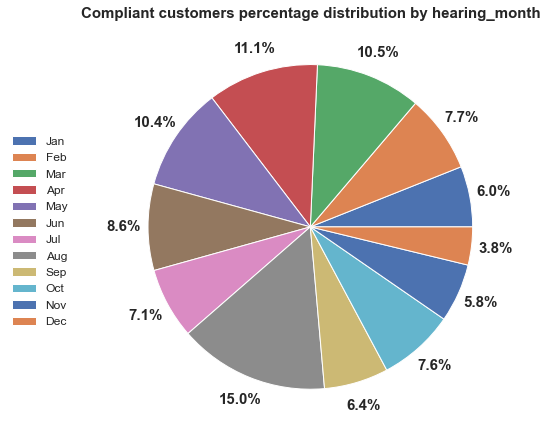

In [84]:
plot_pie(df_train, 'hearing_month', month_ticks, compliance=True, order=order, pct=1.15, legend_pos=(-0.07,0.75))

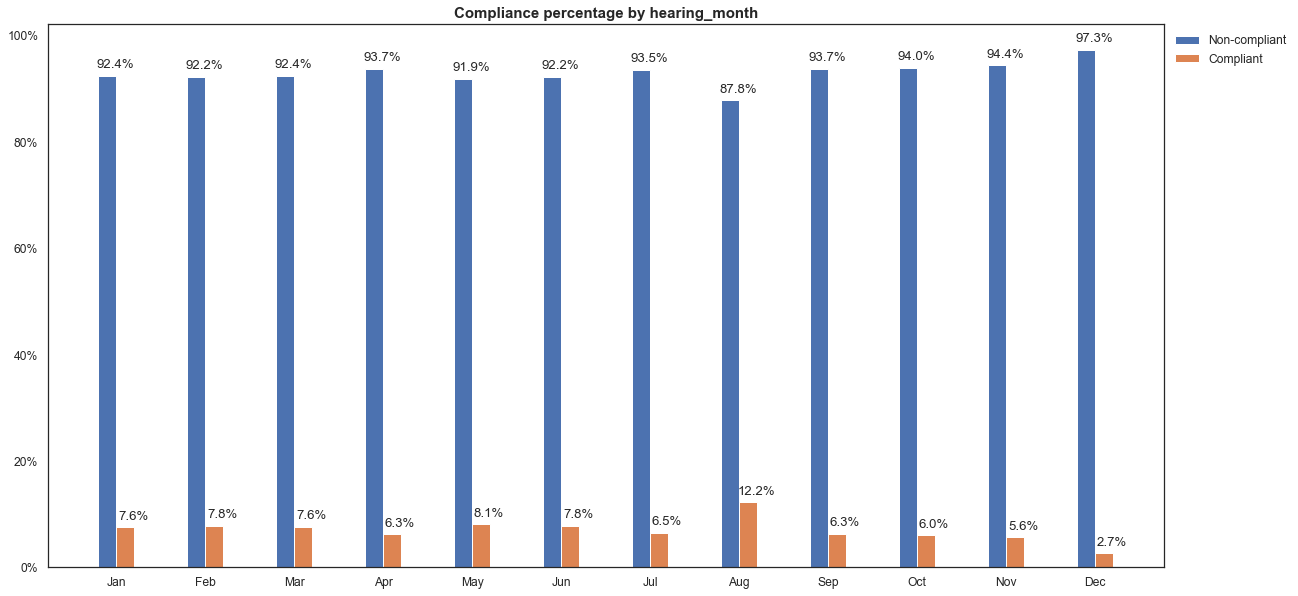

In [85]:
plot_percent_category(df_train, 'hearing_month', order, xticks=month_ticks, compliance=True, xspace=8, legend_pos=(1,1))

### Observations:
* There is not much difference between the compliance ratio of people that have different hearing months

# 3. Compliance Predictive Model <a class='anchor' id='3.'></a>

Since our goal is to predict the probability of a person with determined feature values is going to pay the blight ticket on time (be compliant (compliance = 1)), having a set of data with the labeled values to train our models, we are perfoming a Supervised Learning task of Classification. With this in mind, we can narrow our model choice to some fewer options presented below. The score parameter used to evaluate the models is ROC AUC score.
* Logistic Regression 
* SVC
* Linear SVC
* Decision Tree
* Random Forest
* KNN
* Naive Bayes
* Perceptron
* Stochastic Gradient Decent

## 3.1 Data Preprocessing and Feature Selection <a class='anchor' id='3.1'></a>

In [81]:
def transform(le, data_list):
    """
    This will transform the data_list to id list where the new values get assigned to Unknown class
    :param data_list:
    :return:
    """
    new_data_list = list(data_list)
    for unique_item in np.unique(data_list):
        if unique_item not in le.classes_:
            new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

    return le.transform(new_data_list)

In [82]:
def transform_categorical_features(df, columns):
    cate_features = list(df.select_dtypes(include=['object', 'category']).columns)
    transform_features = [column for column in columns if column in cate_features]

    for cate_col in transform_features:
        try:
            le = LabelEncoder().fit(list(df[cate_col].unique()) + ['Unknown'])
            df[cate_col] = transform(le, df[cate_col])
        except:
            continue
    
    return df

In [88]:
df_train.describe(include=['O'])

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,payment_date,payment_status,compliance_detail,ticket_issued_year,ticket_issued_month,hearing_year,hearing_month,payment_year,payment_month
count,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,96745,22810,96745,96745,96745,96745,96745,96745,22810,22810
unique,4,156,54958,294,8258,1,1,34,1,49309,5667,27,182,3,2164,3,6,9,12,10,12,13,12
top,"Buildings, Safety Engineering & Env Department","Morris, John","APARTMENTS, CARLTON",Rare,PO BOX,Detroit,MI,48227,USA,2008-01-22 09:00:00,2005-12-20 09:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,2007-05-25 00:00:00,NO PAYMENT APPLIED,non-compliant by no payment,2006,09,2006,04,2007,06
freq,59860,8023,102,32363,1939,96745,96745,7219,96745,49,395,41242,41242,83817,93,73935,79062,18071,9329,19758,11927,3693,2767


In [89]:
df_backup = df_train.copy()
cate_features = list(df_train.select_dtypes(include=['object', 'category']).columns)
columns = ['agency_name', 'violation_street_name', 'zip_code', 'ticket_issued_month', 
           'ticket_issued_semester', 'violation_code', 'disposition']

for cate_col in columns:
    try:
        le = LabelEncoder().fit(list(df_train[cate_col].unique()) + ['Unknown'])
        df_train[cate_col] = transform(le, df_train[cate_col])
        df_train[cate_col] = df_train[cate_col].astype('category')
        jb.dump(le,"model/le_{}_blight_ticket.pk;.z".format(cate_col))
    except:
        continue

df_train.head()

<ipython-input-86-74ef0c7f52c3>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if unique_item not in le.classes_:


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,compliance_detail,compliance,owed_amount,owed_amount_band,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_year,hearing_month,hearing_semester,payment_year,payment_month
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27586,0,"Williams, Darrin","Michigan, Covenant House",4311.0,61,2959.0,Martin Luther King,Detroit,MI,7,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,26,Failed To Secure Permit For Lawful Use Of Buil...,2,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,compliant by late payment within 1 month,1.0,855.0,4,2004,3,2,2005,05,1,2005,06
18735,0,"Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,198,8228.0,Mt. Elliott,Detroit,MI,10,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,26,Noncompliance/Grant Condition/BZA/BSE,1,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1,2004,5,2,2005,02,1,NaN,NaN
18733,0,"Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,198,8228.0,Mt. Elliott,Detroit,MI,10,USA,2004-06-16 12:25:00,2005-02-22 15:00:00,26,Noncompliance/Grant Condition/BZA/BSE,1,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,140.0,1,2004,5,2,2005,02,1,NaN,NaN
28204,0,"Williams, Darrin","Inc, Nanno",15307.0,242,1537.0,E. Seven Mile,Detroit,MI,4,USA,2004-07-12 13:30:00,2005-05-31 13:30:00,26,Failed To Secure Permit For Lawful Use Of Buil...,1,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4,2004,6,2,2005,05,1,NaN,NaN
18743,0,"Williams, Darrin","Gardner Resale, GAR",9100.0,269,91.0,Van Dyke,Detroit,MI,12,USA,2004-07-28 12:15:00,2005-02-22 15:00:00,26,Failed To Secure Permit For Lawful Use Of Buil...,1,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,0.0,855.0,4,2004,6,2,2005,02,1,NaN,NaN


In [90]:
df_train.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance,owed_amount,owed_amount_band,hearing_semester
count,9.674500e+04,9.674500e+04,96745.000000,96745.0,96745.0,96745.000000,96745.000000,96745.0,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000
mean,1.031852e+04,7.865159e+03,324.110962,20.0,10.0,30.609737,0.139418,0.0,384.720699,57.096167,327.485197,0.069668,384.581281,3.011525,1.489948
std,4.626965e+04,2.284441e+04,601.721250,0.0,0.0,60.407631,2.659109,0.0,661.510687,163.511476,666.774246,0.254587,661.483612,1.507863,0.499902
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1575.000000,0.000000,52.000000,0.000000,1.000000
25%,4.314000e+03,8.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,230.000000,0.000000,85.000000,0.000000,230.000000,2.000000,1.000000
50%,9.534000e+03,2.668000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000,4.000000,1.000000
75%,1.542500e+04,1.354800e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,305.000000,4.000000,2.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000,11030.000000,4.000000,2.000000


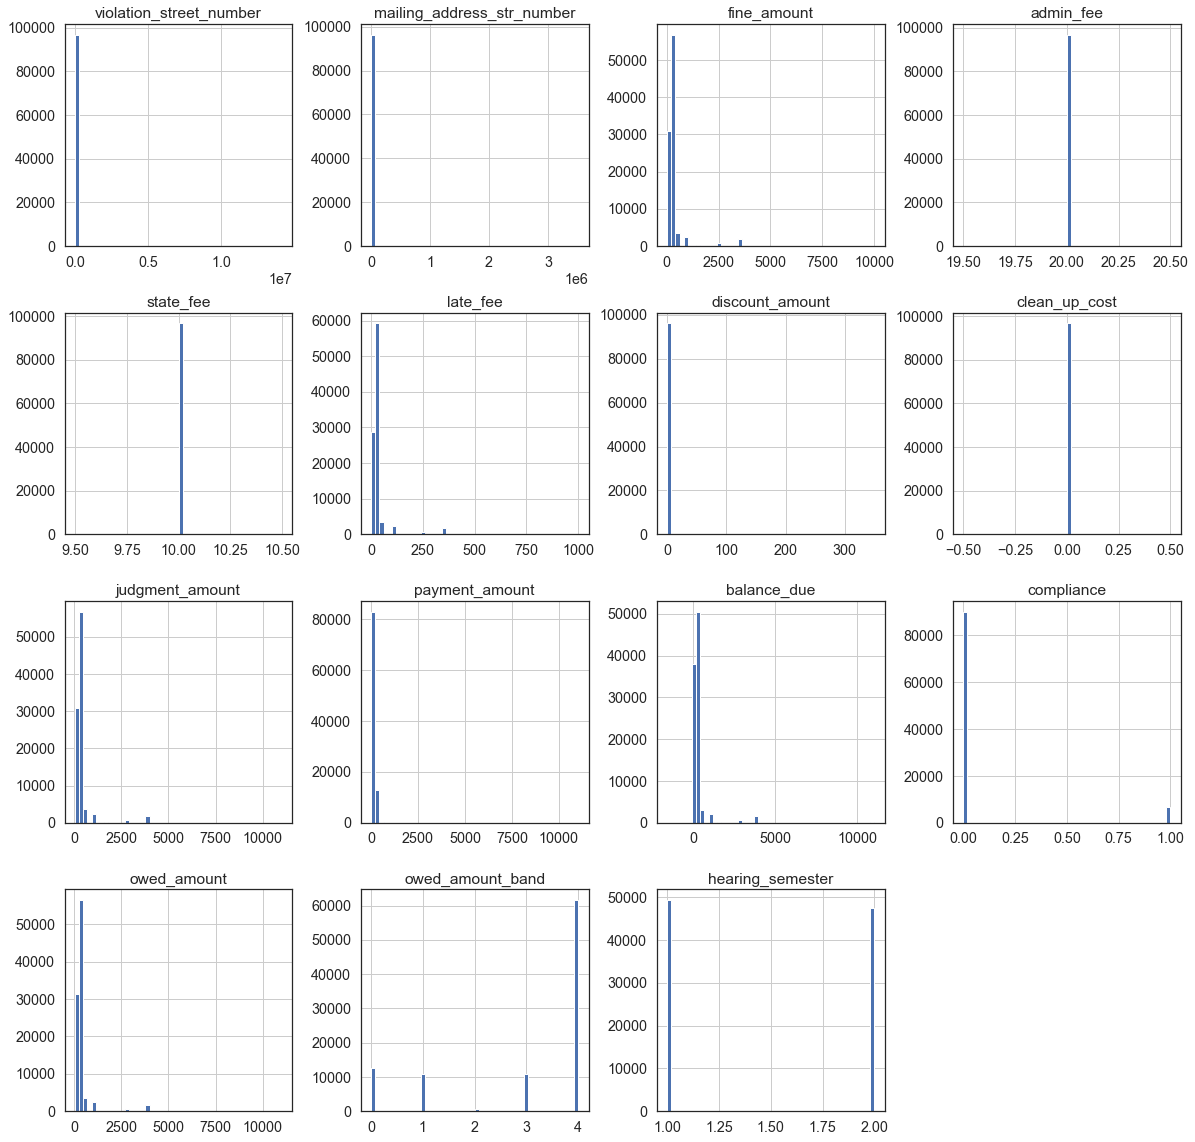

In [91]:
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(20,20)})
ax=df_train.hist(bins=50)

In [92]:
scaler = MinMaxScaler()
df_train['owed_amount'] = np.log1p(df_train['owed_amount'])
df_train['owed_amount'] = scaler.fit_transform(df_train[['owed_amount']].values)

In [93]:
cols = {}
col_list = [['owed_amount'],
            ['owed_amount_band'],
            ['owed_amount', 'agency_name'],
            ['owed_amount', 'violation_street_name'],
            ['owed_amount', 'zip_code'],
            ['owed_amount', 'ticket_issued_month'],
            ['owed_amount', 'ticket_issued_semester'],
            ['owed_amount', 'violation_code'],
            ['owed_amount', 'disposition']]

for col_num in range(len(col_list)):
    cols[col_num+1] = col_list[col_num]

## 3.2 Models <a class='anchor' id='3.2'></a>

In [94]:
models = dict()
models['logistic_regression'] = LogisticRegression(random_state=42)
models['linear_svc'] = LinearSVC(random_state=42)
models['decision_tree'] = DecisionTreeClassifier(random_state=42)
models['random_forest'] = RandomForestClassifier(random_state=42) 
models['knn'] = KNeighborsClassifier(n_neighbors=3)
models['naive_bayes'] = GaussianNB()
models['perceptron'] = Perceptron(random_state=42)
models['sgdc'] = SGDClassifier(random_state=42)

In [ ]:
def blight_model(df, model, columns = ['owed_amount'], cross_val=False):    
    # Prepare the datasets
    X = df[columns]
    y = df['compliance']

    if cross_val == False:
        # Calculate the roc_auc_score
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:,1]

        auc_score = roc_auc_score(y_test, y_pred)
    else:
        clf = model
        auc_score = np.mean(cross_val_score(clf, X, y, scoring='roc_auc', cv=3))
        
    return auc_score

### Logistic Regression

In [ ]:
# Start counting time
start = time.perf_counter()

logistic_scores = {}
for key, value in cols.items():
    logistic_scores[key] = blight_model(df_train, models['logistic_regression'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Logistic Regression', run))

In [ ]:
logistic_scores

### Linear SVC Regression

In [ ]:
# Start counting time
start = time.perf_counter()

linear_svc_scores = {}
for key, value in cols.items():
    linear_svc_scores[key] = blight_model(df_train, model=models['linear_svc'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Linear SVC', run))

In [ ]:
linear_svc_scores

### Decision Tree

In [ ]:
# Start counting time
start = time.perf_counter()

dt_scores = {}
for key, value in cols.items():
    dt_scores[key] = blight_model(df_train, model=models['decision_tree'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Decision Tree', run))

In [ ]:
dt_scores

### Random Forest

In [ ]:
# Start counting time
start = time.perf_counter()

rf_scores = {}
for key, value in cols.items():
    rf_scores[key] = blight_model(df_train, model=models['random_forest'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Random Forest', run))

In [ ]:
rf_scores

### KNN

In [ ]:
# Start counting time
start = time.perf_counter()

knn_scores = {}
for key, value in cols.items():
    knn_scores[key] = blight_model(df_train, model=models['knn'], columns=value, cross_val=True)
    
# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('KNN', run))

In [ ]:
knn_scores

### Naive Bayes

In [ ]:
# Start counting time
start = time.perf_counter()

naive_bayes_scores = {}
for key, value in cols.items():
    naive_bayes_scores[key] = blight_model(df_train, model=models['naive_bayes'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Naive Bayes', run))

In [ ]:
naive_bayes_scores

### Perceptron

In [ ]:
# Start counting time
start = time.perf_counter()

perceptron_scores = {}
for key, value in cols.items():
    perceptron_scores[key] = blight_model(df_train, model=models['perceptron'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('Perceptron', run))

In [ ]:
perceptron_scores

### SGDC

In [ ]:
# Start counting time
start = time.perf_counter()

sgdc_scores = {}
for key, value in cols.items():
    sgdc_scores[key] = blight_model(df_train, model=models['sgdc'], columns=value, cross_val=True)

# Compute time for executing each algo
run = time.perf_counter() - start
print('Computational runtime of {} algorithm: {:.2f} seconds'.format('SGDC', run))

In [ ]:
sgdc_scores

### Model Comparison

In [ ]:
cols

In [ ]:
index=['Logistic Regression', 'Linear SVC', 'Decision Tree', 
       'Random Forest', 'KNN', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent']

df_models = pd.DataFrame([logistic_scores, linear_svc_scores, dt_scores,
              rf_scores, knn_scores, naive_bayes_scores, perceptron_scores, sgdc_scores])
df_models.index = index
df_models['max'] = df_models[df_models.columns].max(axis=1)
df_models = df_models.sort_values(by='max', ascending=False)

column_names = ['owed_amount', 'owed_amount_band'] + [lista[1] for lista in list(cols.values())[2:]] + ['max']
df_models.columns = column_names
df_models

* The first column 'owed_amount' indicates the ROC AUC scores of each machine learning model trained with only the 'owed_amount' feature
* The 2nd~8th columns (feature named columns) indicates the ROC AUC scores of each machine learning model trained with the 'owed_amount' and the respective column name feature
* The max column indicates the maximum ROC AUC score achieve by each machine learning model

In [ ]:
models_features_influences = df_models.apply(lambda x: x - df_models['owed_amount'])
models_features_influences.columns = column_names
models_features_influences

The dataframe above shows how each feature influenced to the respective model in achieving its ROC AUC score. For the Random Forest model, the features below contributed to increase the ROC AUC score:
* ticket_issued_semester
* violation_code
* disposition

Analysing the dataframes above, the best choice of model is: <strong>Random Forest</strong>

I will add the features that most contributed to increase the ROC AUC score in comparison to the model executed with only the 'owed_amount' column.<br>
I will try different combinations of features and choose the one with best score.

In [ ]:
columns = ['owed_amount', 'ticket_issued_semester', 'violation_code', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

In [ ]:
columns = ['owed_amount', 'ticket_issued_semester', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

In [ ]:
columns = ['owed_amount', 'violation_code', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

In [ ]:
columns = ['owed_amount', 'disposition']
rf_score = blight_model(df_train, model=models['random_forest'], columns=columns, cross_val=True)
rf_score

Combining the features 'owed_amount', 'ticket_issued_semester', 'violation_code' and 'disposition', we were able to achieve the ROC AUC score of 0.7872.<br>
I will stick with these features and start tuning the Random Forest hyperparameters.

## 3.3 Hyperparameter Tuning <a class='anchor' id='3.3'></a>

#### Randomized Search CV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


# Prepare the datasets
columns = ['owed_amount', 'ticket_issued_semester', 'violation_code', 'disposition']
X = df_train[columns]
y = df_train['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

In [ ]:
rf_random.best_score_

#### Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [500, 1000, 1500]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='roc_auc', 
                          cv = 3, n_jobs = -1, verbose = 2, random_state=42)

grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
grid_search.best_score_

The grid_search algo had the best score, so I will save this model to use in the streamlit app

## 3.4 Save Model <a class='anchor' id='3.4'></a>

In [ ]:
# Prepare the datasets
columns = ['owed_amount', 'ticket_issued_semester', 'violation_code', 'disposition']
X = df_train[columns]
y = df_train['compliance'] 

rf = RandomForestClassifier(bootstrap=True, max_depth=110, max_features='auto', min_samples_leaf=4, min_samples_split=3, 
                            n_estimators=1500)
rf.fit(X,y)

jb.dump(rf,"model/rf_blight_ticket.pk;.z")
jb.dump(scaler,"model/scaler_blight_ticket.pk;.z")

# 4. First Conclusion <a class='anchor' id='4.'></a>

## 4.1 Payment <a class='anchor' id='4.1'></a>

* Every year, an average amount of `$ 5,314,118.71` of blight tickets is issued
* Every year, an average amount of `$ 4,525,170.77` of the blight tickets is not paid, resulting in a yearly payment percetage of 14.72%
* The total pending payment value of blight tickets, until 2017, is `$ 31,682,555.40`
* Months that contains the highest accumulated amounts of payment: March to June
* Remainders or charges of late or possibly late tickets could be preferably be made from March to June, when people tends to pay more the bills

## 4.2 Compliance <a class='anchor' id='4.2'></a>

* Percentage of compliant people: 6.97%
* Percentage of non-compliant people: 93.03%
* Almost 88% of the non-compliant cases are from people who didn't pay the blight ticket

## 4.3 Model <a class='anchor' id='4.3'></a>

* This is a supervised learning classification task
* A Random Forest Model was used to predict the probability of a person paying the blight ticket on time
* The features used to do the prediction were:
    * owed_amount: Sum of all fines and fees minus the discount amount
    * ticket_issued_semester: The semester when the blight ticket was issued
    * disposition: Judgement type
* Using the cross validation method, the model achieved a ROC AUC score of 0.791937

## 4.4 Next Steps <a class='anchor' id='4.4'></a>

* We have an app that predicts if a determined person will pay the blight ticket within one month from the hearing date
* We need a solution to all old tickets that weren't paid yet
* I'll build a ML model to predict the chance of payment of the blight ticket

# 5. Payment Dataframe <a class='anchor' id='5.'></a>

* In order to predict the chance of a non-compliant person still paying the blight ticket, I'll filter the dataframe to contain only the non-compliant people
* Then I'll drop the compliance and compliance_detail columns, since it's useless to our new dataset

In [42]:
df_pay = df[df['compliance'] == 0].copy()
df_pay.drop('compliance', axis=1, inplace=True)
df_pay.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,compliance_detail,owed_amount,owed_amount_band,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_year,hearing_month,hearing_semester,payment_year,payment_month
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,140.0,1,2004,06,1,2005,02,1,NaN,NaN
18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,48211,USA,2004-06-16 12:25:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,140.0,1,2004,06,1,2005,02,1,NaN,NaN
28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",15307.0,SEVEN MILE,1537.0,E. Seven Mile,Detroit,MI,48205,USA,2004-07-12 13:30:00,2005-05-31 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,855.0,4,2004,07,2,2005,05,1,NaN,NaN
18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",9100.0,VAN DYKE,91.0,Van Dyke,Detroit,MI,48213,USA,2004-07-28 12:15:00,2005-02-22 15:00:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,855.0,4,2004,07,2,2005,02,1,NaN,NaN
18741,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Hardaway, Kevin",20024.0,SCHAEFER,224.0,Schaefer,Detroit,MI,48235,USA,2004-08-05 15:00:00,2005-02-22 15:00:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,855.0,4,2004,08,2,2005,02,1,NaN,NaN


## 5.1 Target Variable <a class='anchor' id='5.1'></a>

The new target variable will be a binary variable that returns 0, if the person completely paid the ticket, and 1 if not

In [43]:
df_pay['payment_status'].value_counts()

NO PAYMENT APPLIED         73935
PAID IN FULL               10943
PARTIAL PAYMENT APPLIED     5127
Name: payment_status, dtype: int64

In [44]:
df_pay['paid'] = [1 if x == 'PAID IN FULL' else 0 for x in df_pay['payment_status']]
df_pay['paid'].value_counts()

0    79062
1    10943
Name: paid, dtype: int64

# 6. Hypothesis <a class='anchor' id='6.'></a>

## 6.1 Hypotheis Creation <a class='anchor' id='6.1'></a>

1. People that owes higher amounts is less likely to pay it
2. People are more likely to pay tickets issued from a determined agency
3. Tickets issued from violations that happended in some places are more likely to be paid
4. Tickets issued from some types of violations are more likely to be paid
5. Tickets that were issued in the first semester are more likely to be paid
6. People that had the hearing in the first semester are more likely to pay the ticket
7. Tickets issued from some judgement types are more likely to be paid
8. Older tickets are less likely to be paid (ticket issued date)
9. Tickets that are late for longer periods are less likely to be paid (hearing date)
10. Tickets with higher discounts are more likely to be paid

## 6.2 Hypotheis Check <a class='anchor' id='6.2'></a>

In [45]:
def add_value_labels(ax, orientation, xspace=0, yspace=0, percentage=False):
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        if orientation == 'v':
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            label = rect.get_height()
        elif orientation == 'h':
            y_value = rect.get_y() + rect.get_height() / 4
            x_value = rect.get_width()
            label = rect.get_width()            

        # Vertical alignment for positive values
        va = 'bottom'

        # Define the label format
        if percentage==True:
            label = "{:.1f}".format(label*100)
        else:
            label = "{:,.0f}".format(label)

        # Create annotation
        ax.annotate(
            label,                     
            (x_value, y_value),        
            xytext=(xspace, yspace),   
            textcoords="offset points",
            ha='center',               
            va=va)                     

In [46]:
def generate_target_categories(df, field, xvalues):
    # create the lists of values
    total = []
    not_paid = []
    paid = []
    
    # initially define the lists elements
    total_values = df[field].value_counts().sort_index()
    not_paid_values = df[df['paid'] == 0][field].value_counts()
    paid_values = df[df['paid'] == 1][field].value_counts()
        
    # redefine lists elements, including 0 for no values for determined index
    for value in xvalues:
        if value in total_values.index:
            total.append(total_values[value])
        else:
            total.append(0)
            
        if value in not_paid_values.index:
            not_paid.append(not_paid_values[value])
        else:
            not_paid.append(0)
        
        if value in paid_values.index:
            paid.append(paid_values[value])
        else:
            paid.append(0)
    
    return total, not_paid, paid

In [47]:
def plot_hist(df, field, subplot=(1,2,1), hist_type='normal', bins=25):   
    # create the subplot figure
    ax = plt.subplot(subplot[0], subplot[1], subplot[2])
    
    # create the bar plots
    if hist_type == 'normal':
        image = 'images/' + field + '_Bar'
        title = 'Tickets by {}'.format(field)
        ax.hist(df[field], bins=bins)
    elif hist_type == 'paid':
        image = 'images/' + field + '_Bar_Paid'
        title = 'Full paid tickets by {}'.format(field)
        ax.hist(df[df['paid'] == 1][field], bins=bins)
    elif hist_type == 'not_paid':
        image = 'images/' + field + '_Bar_Not_Paid'
        title = 'Not paid tickets by {}'.format(field)
        ax.hist(df[df['paid'] == 0][field], bins=bins)
    
    # define chart features
    ax.set_title(title, fontweight='bold',size=15)
    
    #plt.savefig(image)

In [48]:
def plot_percent_category(df, field, xvalues, subplot=(1,2,1), pay_ratio=False, xticks=None, xspace=0, yspace=0, labels=True, xticks_rotation=0):
    total, not_paid, paid = generate_target_categories(df, field, xvalues)
            
    if xticks == None:
        xticks = xvalues

    # create the subplot figure
    ax = plt.subplot(subplot[0], subplot[1], subplot[2])
    w = 1
    folds = np.linspace(5,len(xvalues)*5, len(xvalues))
    
    # create the bar plots
    if pay_ratio == False:
        image = 'images/' + field + '_Bar'
        title = 'Tickets by {} and paid ratio'.format(field)
        ax.bar([element - w/2 for element in folds], [number if sum(total) == 0 else number / sum(total) for number in paid], width=w, color='red', alpha=0.85)
        ax.bar([element + w/2 for element in folds], [number if sum(total) == 0 else number / sum(total) for number in not_paid], width=w, color='darkgrey', alpha=0.85)
    else:
        image = 'images/' + field + '_Bar_Paid'
        title = 'Paid ratio by {}'.format(field)
        ax.bar([element - w/2 for element in folds], [number if total == 0 else number / total for number, total in zip(paid, total)], width=w, color='red', alpha=0.85)
        ax.bar([element + w/2 for element in folds], [number if total == 0 else number / total for number, total in zip(not_paid, total)], width=w, color='darkgrey', alpha=0.85)
        
    # define if the value labels must appear in chart
    if labels == True:
        add_value_labels(ax, orientation='v', percentage=True, xspace=xspace)
        
    # set the y axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # define chart features
    ax.set_xticks(folds)
    ax.set_xticklabels(xticks, rotation=xticks_rotation)
    ax.set_title(title, fontweight='bold',size=15)
    
    #plt.savefig(image)

In [49]:
def plot_line_percent_category(df, field, xvalues, subplot=(1,1,1), pay_ratio=False):    
    total, not_paid, paid = generate_target_categories(df, field, xvalues)

    ax = plt.subplot(subplot[0], subplot[1], subplot[2])
    
    if pay_ratio == False:
        image = 'images/' + field + '_Bar'
        title = 'Tickets by {} and paid ratio'.format(field)
        ax.plot(xvalues, [number if sum(total) == 0 else number / sum(total) for number in paid], '-r')
        ax.plot(xvalues, [number if sum(total) == 0 else number / sum(total) for number in not_paid], '-b')
    else:
        image = 'images/' + field + '_Bar_Compliance'
        title = 'Paid Tickets by {}'.format(field)
        ax.plot(xvalues, [number if total == 0 else number / total for number, total in zip(paid, total)], '-r')
        ax.plot(xvalues, [number if total == 0 else number / total for number, total in zip(not_paid, total)], '-b')
        
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.title(title, fontweight='bold',size=15)
    #plt.savefig(image)

In [50]:
def plot_pie(df, field, subplot=(1,2,1), pay_ratio=False, order=None, size=(16,8), pct=0.75, startangle=0, pct_pos={}):
    # Define if only the respondent customers will be considered
    if pay_ratio == False:
        image = 'images/' + field + '_Pie'
        entries = df[field].value_counts()
        title = 'Tickets by {}'.format(field)
    else:
        image = 'images/' + field + '_Pie_Cardio'
        entries = df[df['paid'] == 1][field].value_counts()
        title = 'Paid Tickets customers by {}'.format(field)
    
    # Define if there is an exact order of values to be plotted
    if order == None:
        paid = list(entries)
    else:
        paid = []
        for value in order[::-1]:
            if value in entries.index:
                paid.append(entries[value])
        paid = paid[::-1]
    
    # Set the figure parameters
    sns.set(style='white',font_scale=1.1, rc={'figure.figsize':size})

    # Create pie chart
    ax = plt.subplot(subplot[0], subplot[1], subplot[2])
    plt.title(title, fontweight='bold',size=15)
    _, _, autopcts = ax.pie(paid, autopct='%1.1f%%', pctdistance=pct, startangle=startangle)
    plt.setp(autopcts, **{'fontsize':15, 'fontweight': 'bold'})
    
    # Adjust pct positions
    for key, value in pct_pos.items():
        pct = autopcts[key]
        d=1
        xi,yi = pct.get_position()
        ri = np.sqrt(xi**2+yi**2)
        phi = np.arctan2(yi,xi)
        x = d*ri*np.cos(phi)+value[0]
        y = d*ri*np.sin(phi)+value[1]
        pct.set_position((x,y))

    #plt.savefig(image)

In [51]:
def generate_num_chart_dashboard(df, field, order, size=(20,15), line_legend_pos=(0.05,1.15), bins=25):
    plt.figure(figsize=size)
    plot_hist(df, field, subplot=(2,2,1), hist_type='not_paid', bins=bins)
    plot_hist(df, field, subplot=(2,2,2), hist_type='paid', bins=bins)
    plot_line_percent_category(df, field, order, subplot=(2,2,3))
    plot_line_percent_category(df, field, order, subplot=(2,2,4), pay_ratio=True)
    plt.legend(['Paid', 'Not paid'], bbox_to_anchor=line_legend_pos, framealpha=0.0, prop={'size': 12})
    plt.show()

In [52]:
def generate_cate_chart_dashboard(df, field, order, ticks, size=(20,15), pct=1.15, pie_legend_pos=(-0.15, 0.95), bar_legend_pos=(0.05,1.15), xticks_rotation=0):
    plt.figure(figsize=size)
    plot_pie(df, field, subplot=(2,2,1), order=order, pct=pct)
    plot_pie(df, field, subplot=(2,2,2), pay_ratio=True, order=order, pct=pct)
    plt.legend(ticks, bbox_to_anchor=pie_legend_pos, framealpha=0.0, prop={'size': 12})
    plot_percent_category(df, field, order, subplot=(2,2,3), xticks=ticks, xticks_rotation=xticks_rotation)
    plot_percent_category(df, field, order, subplot=(2,2,4), xticks=ticks, pay_ratio=True, xticks_rotation=xticks_rotation)
    plt.legend(['Paid', 'Not paid'], bbox_to_anchor=bar_legend_pos, framealpha=0.0, prop={'size': 12})
    plt.show()

In [53]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - ((k-1)*(r-1))/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

### 6.2.1 Hypotheis 1: People that owes higher amounts is less likely to pay it

<b>FALSE: Low relevance</b>

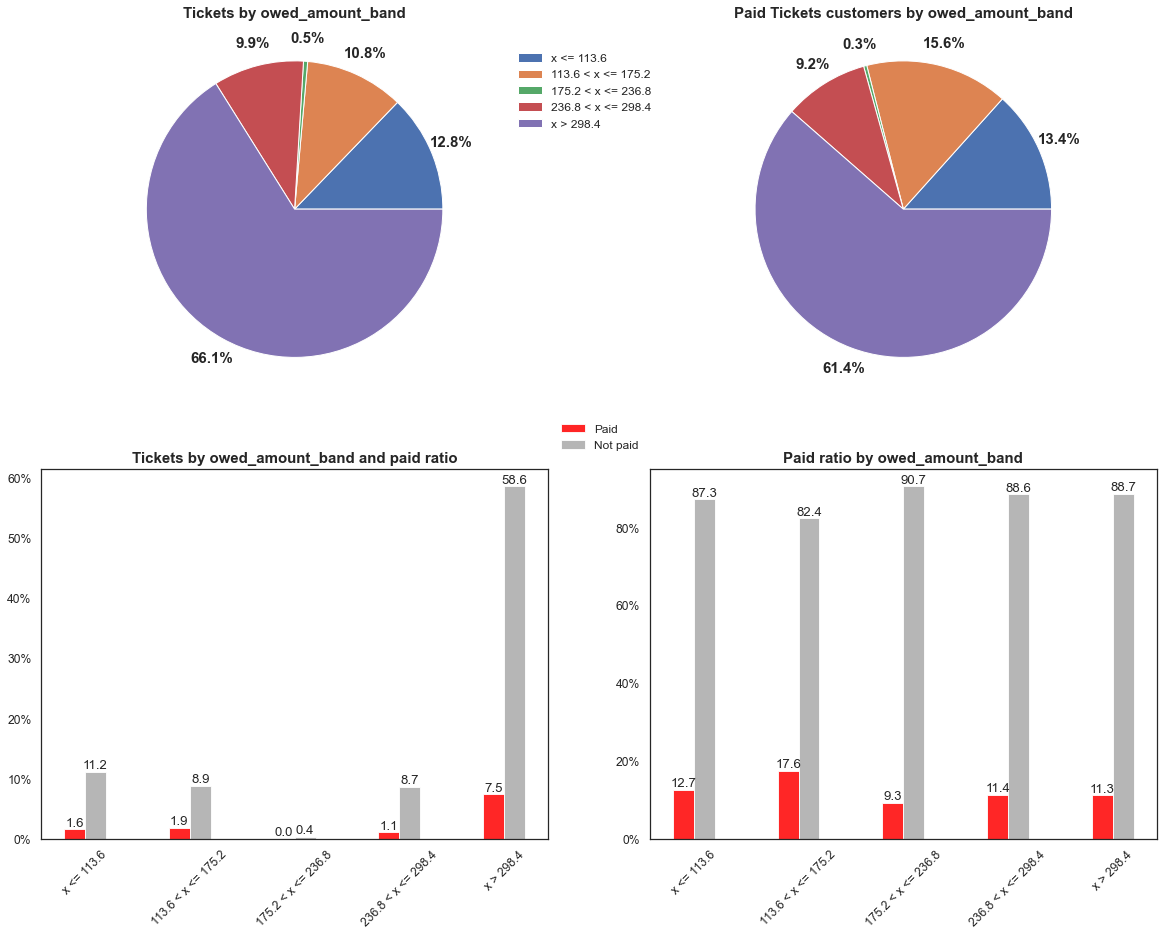

In [54]:
owed_amount_ticks = ['x <= 113.6', '113.6 < x <= 175.2', '175.2 < x <= 236.8', '236.8 < x <= 298.4', 'x > 298.4']
order = list(np.linspace(0,4,5))
generate_cate_chart_dashboard(df_pay, 'owed_amount_band', order, owed_amount_ticks, bar_legend_pos=(0,1.15), xticks_rotation=45)

* There are more tickets which owed amount is above 298.4 (66.1%)
* Among all paid tickets, the majority has an owed amount above 298.4 (61.4%)
* The majority of tickets are not paid with owed amount above 298.4 (58.6%)
* There is no linear relation between the owed amount and the ticket payment ratio

### 6.2.2 Hypotheis 2: People are more likely to pay tickets issued from a determined agency

<b>TRUE: Low relevance</b>

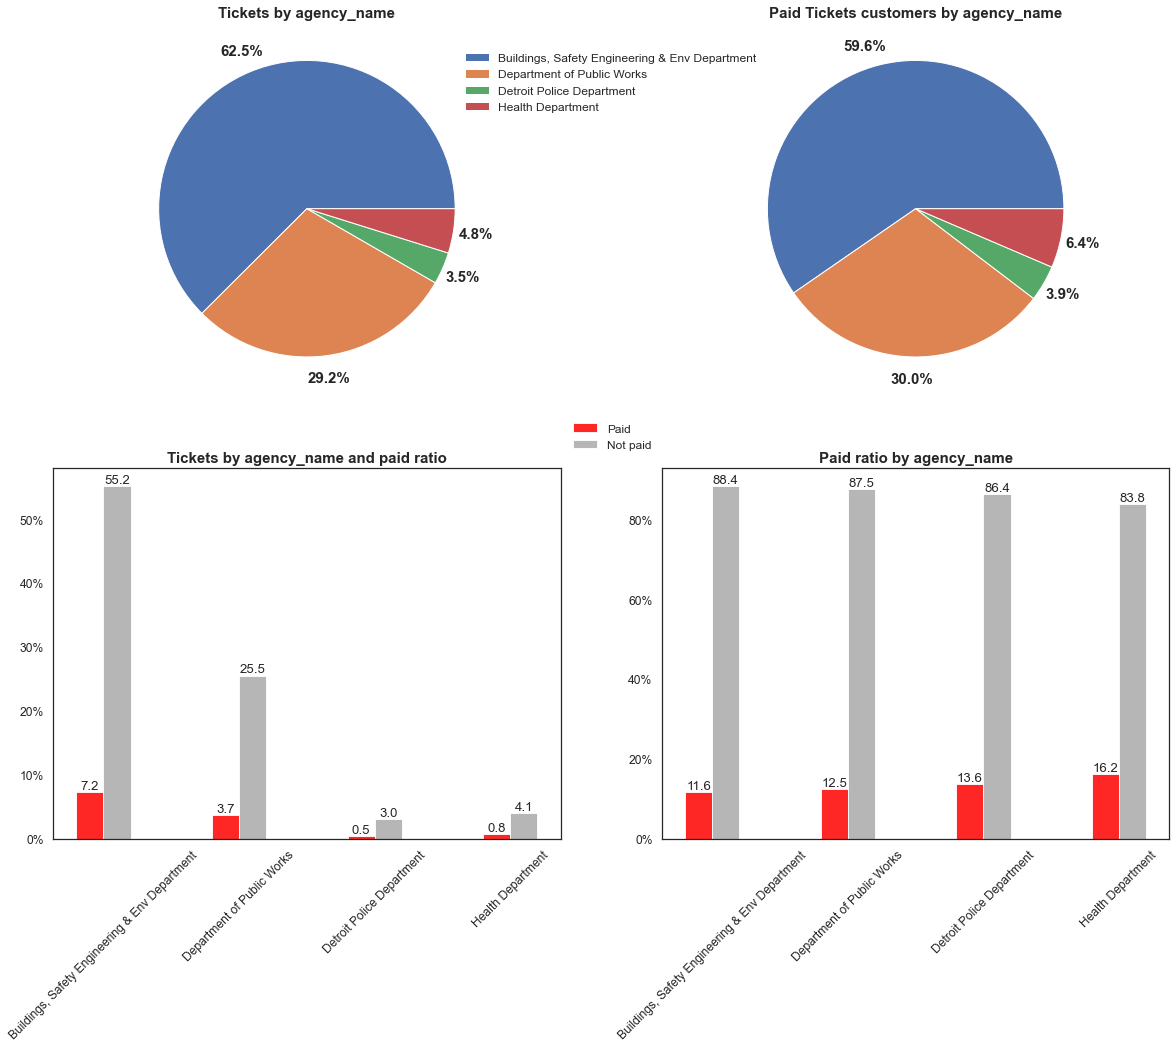

In [55]:
agency_ticks = list(df_pay['agency_name'].value_counts().sort_index().index)
generate_cate_chart_dashboard(df_pay, 'agency_name', agency_ticks, agency_ticks, pie_legend_pos=(0.1, 0.95), bar_legend_pos=(0,1.15), xticks_rotation=45)

* There are more tickets which issued by 'Buildings, Safety Engineering & env Department' (62.5%)
* Among all paid tickets, the majority was issued by 'Buildings, Safety Engineering & env Department' (59.6%)
* The majority of tickets are not paid and issued by 'Buildings, Safety Engineering & env Department' (55.2%)
* There is a little difference between the ticket payment ratio of distincts agencies

### 6.2.3 Hypotheis 3: Tickets issued from violations that happended in some places are more likely to be paid

<b>FALSE: Low relevance</b>

In [56]:
#violation_street_name_ticks = list(df_pay['violation_street_name'].value_counts().sort_index().index)
#generate_num_chart_dashboard(df_pay, 'violation_street_name', violation_street_name_ticks, size=(20,15), line_legend_pos=(0.0,1.15))

<p align='center'>
    <img src='images/violation_street_paid_dash.png'>
</p>

* There is no evident correlation between the 2 variables

### 6.2.4 Hypotheis 4: Tickets issued from some types of violations are more likely to be paid

<b>FALSE: Low relevance</b>

In [57]:
#violation_code_ticks = list(df_pay['violation_code'].value_counts().sort_index().index)
#generate_num_chart_dashboard(df_pay, 'violation_code', violation_code_ticks, size=(20,15), line_legend_pos=(0.0,1.15))

<p align='center'>
    <img src='images/violation_code_paid_dash.png'>
</p>

* There is no evident correlation between the 2 variables

### 6.2.5 Hypotheis 5: Tickets that were issued in the first semester are more likely to be paid

<b>TRUE: Low relevance</b>

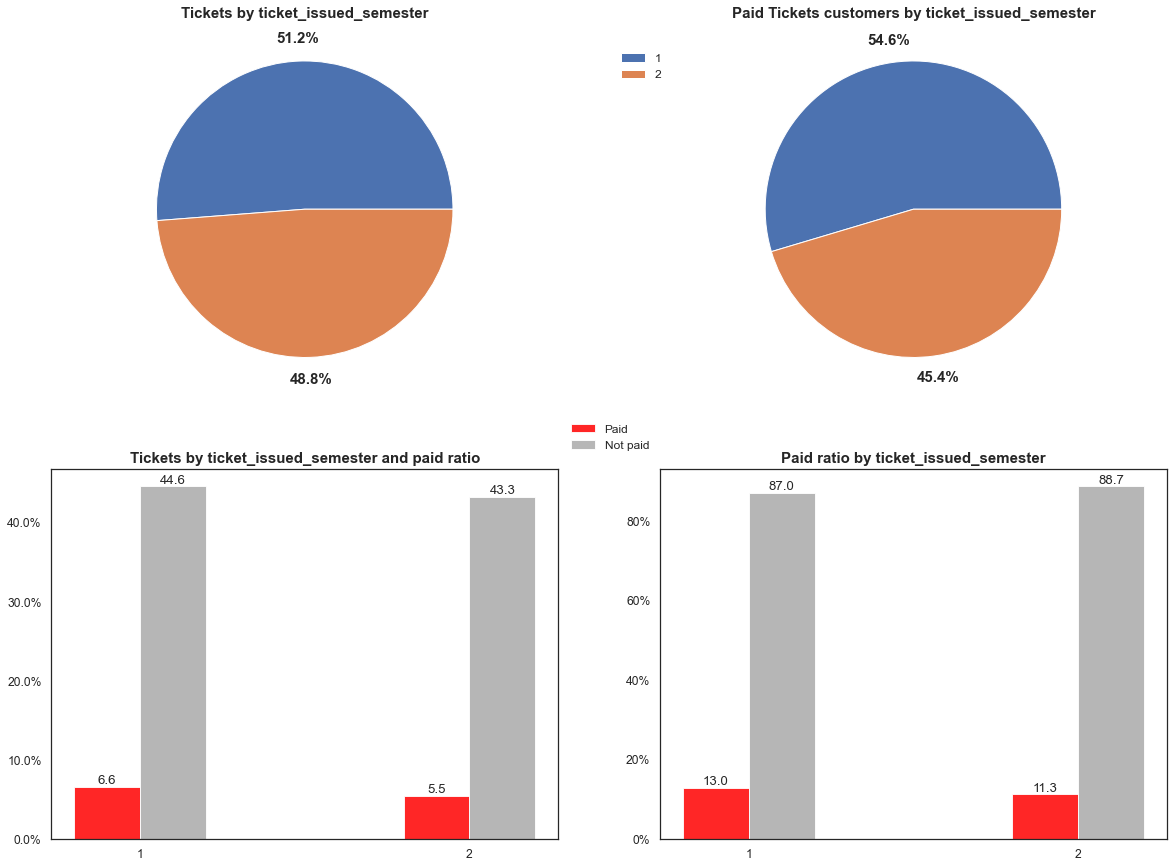

In [58]:
ticket_issued_semester_ticks = [1,2]
generate_cate_chart_dashboard(df_pay, 'ticket_issued_semester', ticket_issued_semester_ticks, ticket_issued_semester_ticks, bar_legend_pos=(0,1.15))

* There are more tickets issued in the first semester (51.2%)
* Among all paid tickets, the majority are tickets issued in the first semester (54.6%)
* The majority of tickets are not paid and issued in the first semester (44.6%)
* Tickets issued in the first semester have a little higher payment ratio

### 6.2.6 Hypotheis 6: People that had the hearing in the first semester are more likely to pay the ticket

<b>TRUE: Low relevance</b>

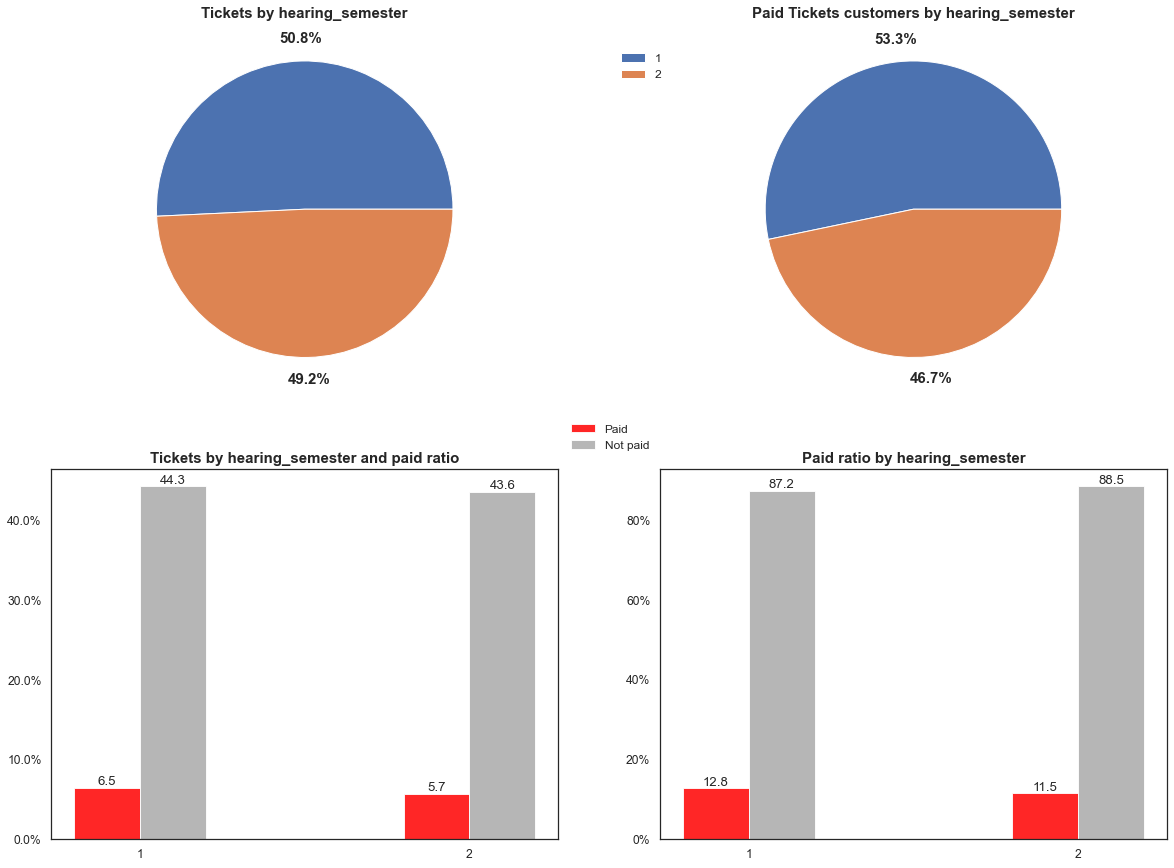

In [59]:
hearing_semester_ticks = [1,2]
generate_cate_chart_dashboard(df_pay, 'hearing_semester', hearing_semester_ticks, hearing_semester_ticks, bar_legend_pos=(0,1.15))

* There are more tickets with hearing date in the first semester (50.8%)
* Among all paid tickets, the majority are tickets with hearing date in the first semester (53.3%)
* The majority of tickets are not paid and with hearing date in the first semester (44.3%)
* Tickets with hearing date in the first semester have a little higher payment ratio

### 6.2.7 Hypotheis 7: Tickets issued from some judgement types are more likely to be paid

<b>TRUE: High relevance</b>

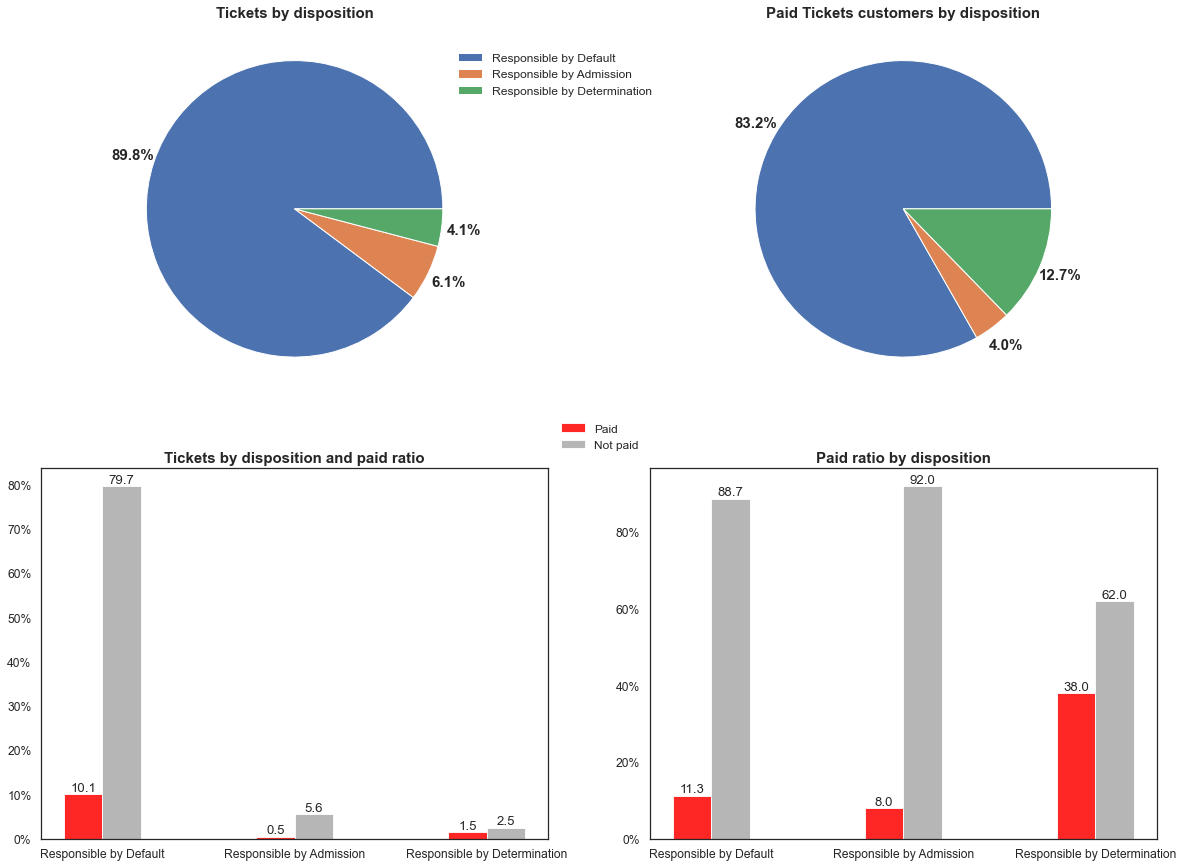

In [60]:
disposition_ticks = list(df_pay['disposition'].value_counts().index)
generate_cate_chart_dashboard(df_pay, 'disposition', disposition_ticks, disposition_ticks, bar_legend_pos=(0,1.15))

* There are more people judged by default (89.8%)
* Among all paid tickets, the majority are from people judged by default (83.2%)
* The majority of tickets are not paid and from people judged by default (79.7%)
* The payment ratio of people judged by determination is way higher than the other types

### 6.2.8 Hypotheis 8: Older tickets are less likely to be paid (ticket issued date)

<b>FALSE: Medium relevance</b>

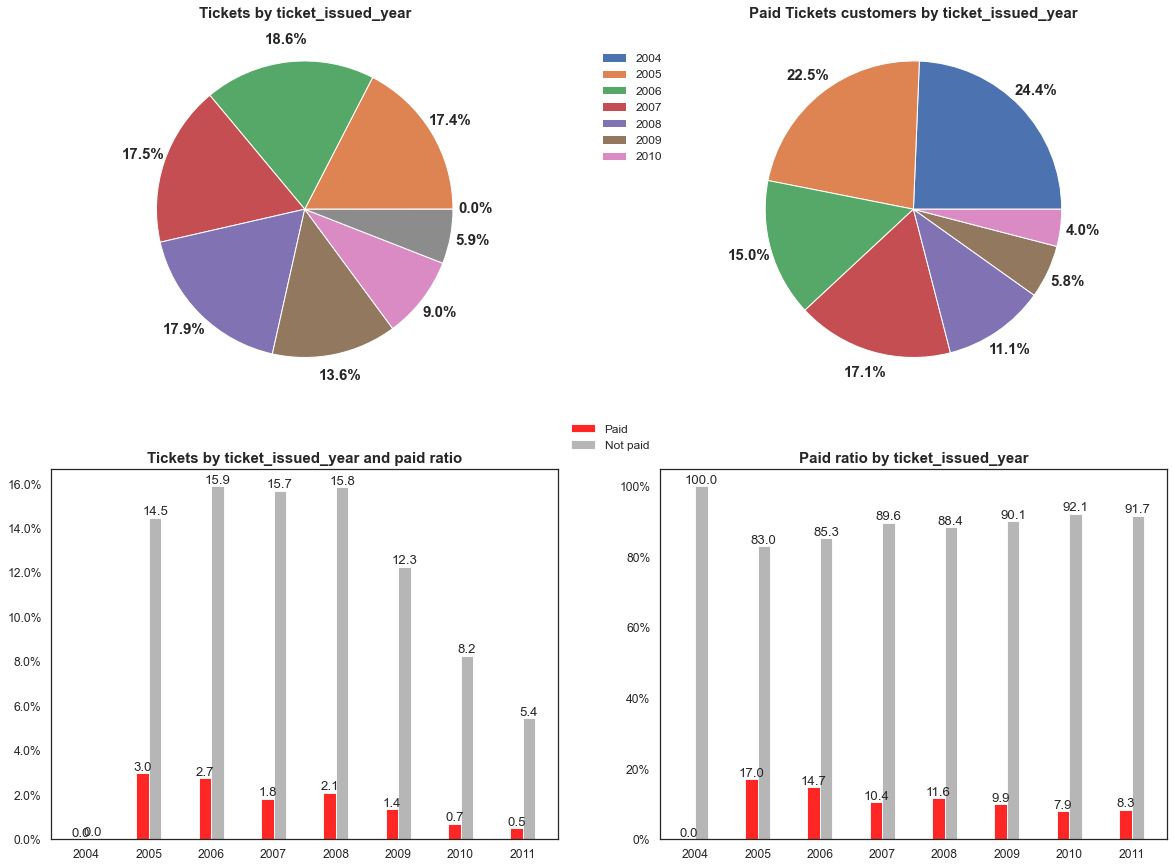

In [61]:
ticket_issued_year_ticks = list(df_pay['ticket_issued_year'].value_counts().sort_index().index)
generate_cate_chart_dashboard(df_pay, 'ticket_issued_year', ticket_issued_year_ticks, ticket_issued_year_ticks, bar_legend_pos=(0,1.15))

* There are more tickets issued in 2006 (18.6%)
* Among all paid tickets, the majority were issued 2004 (24.4%)
* The majority of tickets were issued in 2006 and are not paid (15.9%)
* It seems that older tickets have a higher payment ratio

### 6.2.9 Hypotheis 9: Tickets that are late for longer periods are less likely to be paid (hearing date)

<b>FALSE: Medium relevance</b>

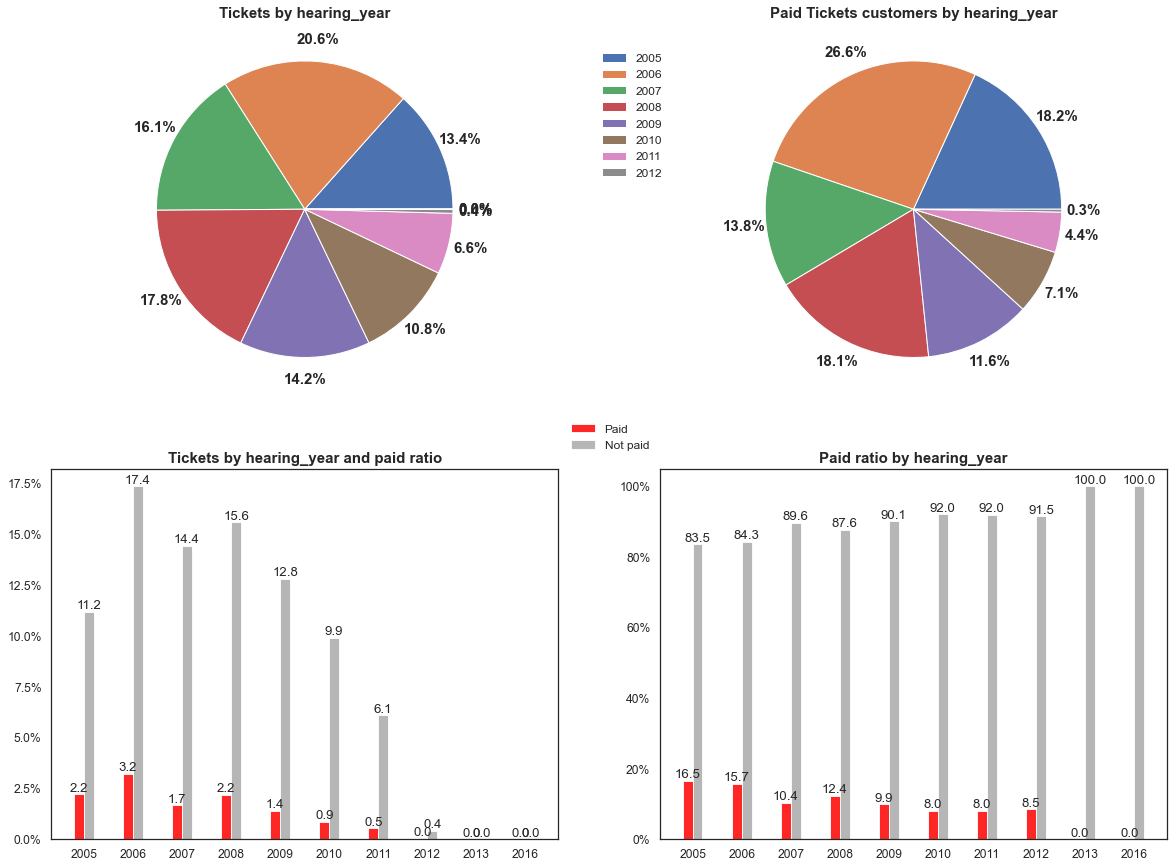

In [62]:
hearing_year_ticks = list(df_pay['hearing_year'].value_counts().sort_index().index)
generate_cate_chart_dashboard(df_pay, 'hearing_year', hearing_year_ticks, hearing_year_ticks, bar_legend_pos=(0,1.15))

* There are more tickets which hearing was scheduled in 2006 (20.6%)
* Among all paid tickets, the majority had the hearing scheduled in 2006 (26.6%)
* The majority of tickets had the hearing scheduled in 2006 and are not paid (17.4%)
* It seems that tickets with older hearing dates have a higher payment ratio

### 6.2.10 Hypotheis 10: Tickets with higher discounts are more likely to be paid

<b>TRUE: High relevance</b>

In [63]:
df_pay['discount_amount'].value_counts()

0.0     89961
25.0       16
20.0        9
10.0        9
5.0         7
50.0        3
Name: discount_amount, dtype: int64

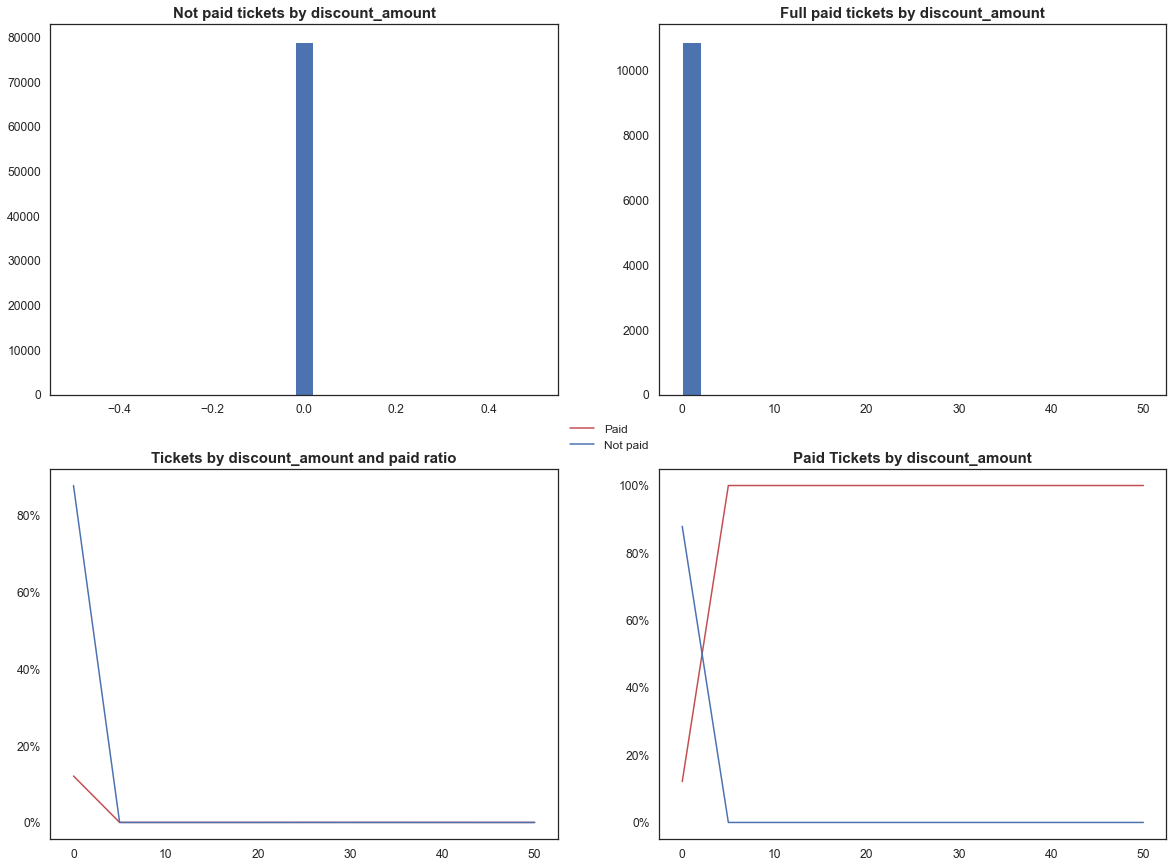

In [64]:
discount_ticks = list(df_pay['discount_amount'].value_counts().sort_index().index)
generate_num_chart_dashboard(df_pay, 'discount_amount', discount_ticks, size=(20,15), line_legend_pos=(0.0,1.15))

* Almost all tickets had 0 discount
* Among all paid tickets, almost all of them had 0 discount
* It's a small amount of tickets with discount, but all of them were paid
* It may be a good idea to give discounts to some old tickets that doesn't have a good chance to be paid

## 6.3 Hypotheis Overview <a class='anchor' id='6.3'></a>

1. People that owes higher amounts is less likely to pay it
2. People are more likely to pay tickets issued from a determined agency
3. Tickets issued from violations that happended in some places are more likely to be paid
4. Tickets issued from some types of violations are more likely to be paid
5. Tickets that were issued in the first semester are more likely to be paid
6. People that had the hearing in the first semester are more likely to pay the ticket
7. Tickets issued from some judgement types are more likely to be paid
8. Older tickets are less likely to be paid (ticket issued date)
9. Tickets that are late for longer periods are less likely to be paid (hearing date)
10. Tickets with higher discounts are more likely to be paid

In [65]:
hypothesis = {1: ':arrow_up: Owed Amount : :arrow_down: Pay Chance',
              2: 'Agency Name :arrow_up_down: Pay Chance',
              3: 'Violation Place :arrow_up_down: Pay Chance',
              4: 'Violation Code :arrow_up_down: Pay Chance',
              5: 'Issued in 1st Semester : :arrow_up: Pay Chance',
              6: 'Hearing in 1st Semester : :arrow_up: Pay Chance',
              7: 'Judgement Type :arrow_up_down: Pay Chance',
              8: 'Older tickets : :arrow_down: Pay Chance',
              9: 'Older hearing dates : :arrow_down: Pay Chance',
             10: ':arrow_up: Discount : :arrow_up: Pay Chance'
             }

validation = [0,1,0,0,1,1,1,0,0,1]
validation = [':thumbsup:' if x==1 else ':x:' if x==0 else ':grey_question:' for x in validation]

relevance = [0,0,0,0,0,0,2,1,1,2]
relevance = ['High' if x==2 else 'Medium' if x == 1 else 'Low' for x in relevance]

df_hypothesis = pd.Series(hypothesis)
df_hypothesis = pd.DataFrame({'Hypothesis':df_hypothesis.index, 'Description': df_hypothesis.values})
df_hypothesis['Description'] = df_hypothesis['Description'].apply(lambda x: emoji.emojize(x, use_aliases=True))
df_hypothesis['Status'] = validation
df_hypothesis['Status'] = df_hypothesis['Status'].apply(lambda x: emoji.emojize(x, use_aliases=True))
df_hypothesis['Relevance'] = relevance
df_hypothesis.index = df_hypothesis['Hypothesis']
df_hypothesis.drop('Hypothesis', axis=1, inplace=True)

print('⬆️: Higher')
print('⬇️: Lower value of field')
print('↕️: Second field ratio varies according to first field category')
print('👍: Hypothesis validated')
print('❌: Hypothesis rejected')
print('❔: Not enough evidence')

df_hypothesis

⬆️: Higher
⬇️: Lower value of field
↕️: Second field ratio varies according to first field category
👍: Hypothesis validated
❌: Hypothesis rejected
❔: Not enough evidence


,Description,Status,Relevance
Hypothesis,,,
1,⬆️ Owed Amount : ⬇️ Pay Chance,❌,Low
2,Agency Name ↕️ Pay Chance,👍,Low
3,Violation Place ↕️ Pay Chance,❌,Low
4,Violation Code ↕️ Pay Chance,❌,Low
5,Issued in 1st Semester : ⬆️ Pay Chance,👍,Low
6,Hearing in 1st Semester : ⬆️ Pay Chance,👍,Low
7,Judgement Type ↕️ Pay Chance,👍,High
8,Older tickets : ⬇️ Pay Chance,❌,Medium
9,Older hearing dates : ⬇️ Pay Chance,❌,Medium


# 7. Paid Predictive Model <a class='anchor' id='7.'></a>

## 7.1 Data Preprocessing <a class='anchor' id='7.1'></a>

### 7.1.1 Scalling

In [66]:
df_pay.describe()

,violation_street_number,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,owed_amount,owed_amount_band,ticket_issued_semester,hearing_semester,paid
count,9.000500e+04,9.000500e+04,90005.000000,90005.0,90005.0,90005.000000,90005.000000,90005.0,90005.000000,90005.000000,90005.000000,90005.000000,90005.000000,90005.000000,90005.000000,90005.000000
mean,1.035061e+04,7.991754e+03,332.120104,20.0,10.0,32.024104,0.009499,0.0,394.144209,43.157062,350.977648,394.134709,3.056630,1.487728,1.492439,0.121582
std,4.793350e+04,2.356438e+04,618.266559,0.0,0.0,62.007266,0.496274,0.0,679.879121,146.387531,683.982925,679.880766,1.498478,0.499852,0.499946,0.326804
min,0.000000e+00,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-1240.000000,55.000000,0.000000,1.000000,1.000000,0.000000
25%,4.336000e+03,8.440000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,250.000000,3.000000,1.000000,1.000000,0.000000
50%,9.573000e+03,2.745000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,305.000000,4.000000,1.000000,1.000000,0.000000
75%,1.542500e+04,1.365300e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,305.000000,4.000000,2.000000,2.000000,0.000000
max,1.415411e+07,3.511219e+06,10000.000000,20.0,10.0,1000.000000,50.000000,0.0,11030.000000,11030.000000,11030.000000,11030.000000,4.000000,2.000000,2.000000,1.000000


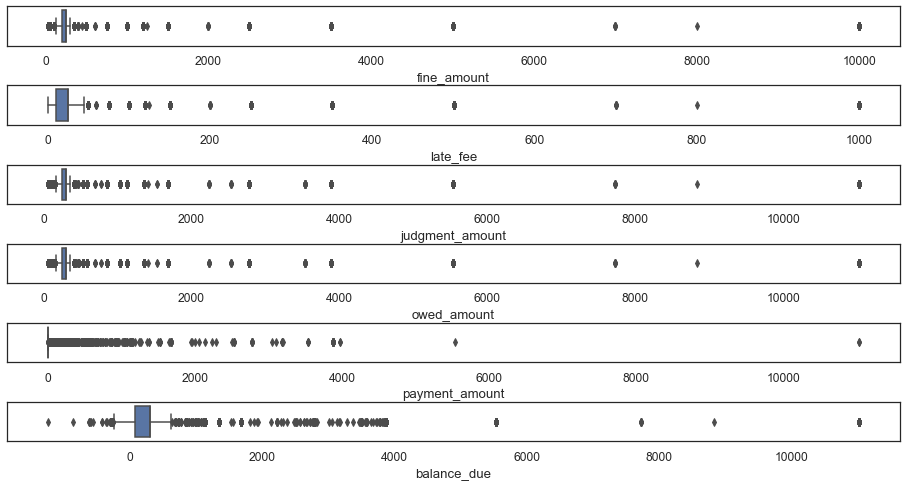

In [67]:
num_cols_scale = ['fine_amount', 'late_fee', 'judgment_amount', 'owed_amount', 'payment_amount', 'balance_due']

col_num = 1
for col in num_cols_scale: 
    plt.subplot(6, 1, col_num)
    sns.boxplot(x=col, data=df_pay)
    col_num += 1

plt.subplots_adjust(hspace=1)
plt.show()

Since there is a high impact of outliers in all variables, let's use the robust scaler

In [83]:
df_pay_scale = df_pay.copy()

for col in num_cols_scale:
    rs_scaler = RobustScaler()
    df_pay_scale[col] = rs_scaler.fit_transform(df_pay_scale[[col]].values)
    jb.dump(rs_scaler, 'model/rs_scaler_{}.pk;.z'.format(col))

### 7.1.2 Label Encoding

In [84]:
# drop unecessary columns, already used to create other through feature engineering or transformation
cols_drop = ['inspector_name', 'violator_name', 'violation_street_number', 'mailing_address_str_number', 'city',
             'state', 'zip_code', 'country', 'ticket_issued_date', 'hearing_date', 'payment_date',
            'payment_year', 'payment_month']
df_pay_scale.drop(cols_drop, axis=1, inplace=True)

In [85]:
#cate_cols = ['agency_name', 'violation_street_name', 'ticket_issued_year', 
#           'hearing_year', 'violation_code', 'disposition']
cate_cols = list(df_pay_scale.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns)

for cate_col in cate_cols:
    try:
        le = LabelEncoder().fit(list(df_pay_scale[cate_col].unique()) + ['Unknown'])
        df_pay_scale[cate_col] = transform(le, df_pay_scale[cate_col])
        df_pay_scale[cate_col] = df_pay_scale[cate_col].astype('category')
        #jb.dump(le,"model/le_{}_paid.pk;.z".format(cate_col))
    except:
        continue

df_pay_scale.head()

<ipython-input-81-74ef0c7f52c3>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if unique_item not in le.classes_:


,agency_name,violation_street_name,mailing_address_str_name,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_status,compliance_detail,owed_amount,owed_amount_band,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_year,hearing_month,hearing_semester,paid
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,
18735,0,1070,4291,63,130,1,-3.0,20.0,10.0,-1.000000,0.0,0.0,-3.0,0.0,-0.75,0,2,-3.0,5,0,5,1,0,1,1,0
18733,0,1070,4291,63,130,1,-3.0,20.0,10.0,-1.000000,0.0,0.0,-3.0,0.0,-0.75,0,2,-3.0,5,0,5,1,0,1,1,0
28204,0,1329,2005,65,42,1,10.0,20.0,10.0,3.333333,0.0,0.0,10.0,0.0,2.50,0,2,10.0,5,0,6,2,0,4,1,0
18743,0,1474,6127,65,42,1,10.0,20.0,10.0,3.333333,0.0,0.0,10.0,0.0,2.50,0,2,10.0,5,0,6,2,0,1,1,0
18741,0,1311,5818,65,42,1,10.0,20.0,10.0,3.333333,0.0,0.0,10.0,0.0,2.50,0,2,10.0,5,0,7,2,0,1,1,0


## 7.2 Feature Selection <a class='anchor' id='7.2'></a>

### 7.2.1 Manual Selection

<AxesSubplot:>

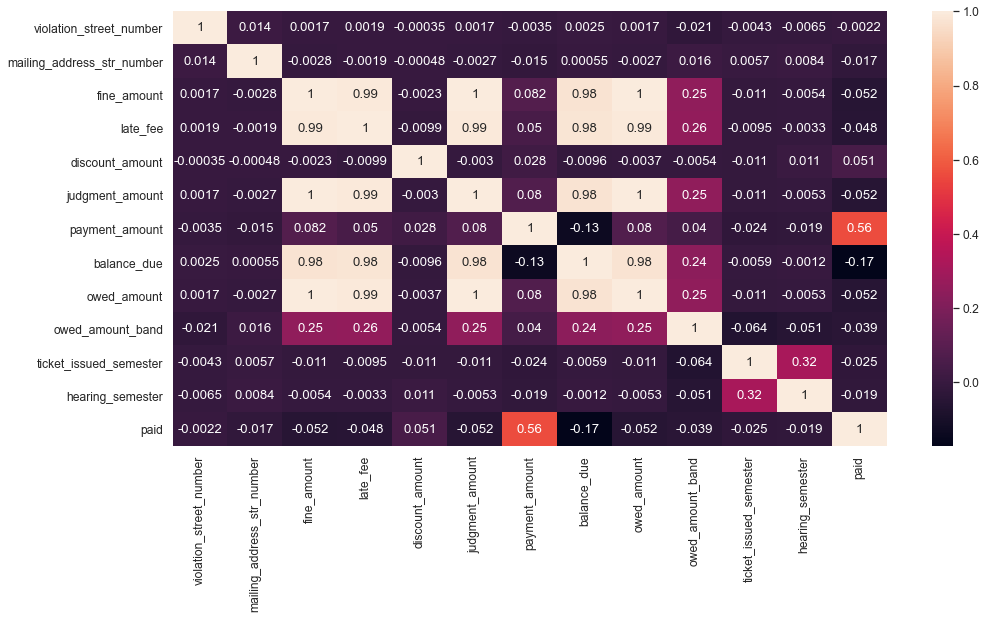

In [86]:
sns.heatmap(df_pay.drop(['admin_fee', 'state_fee', 'clean_up_cost'], axis=1).corr( method='pearson' ), annot=True )

<AxesSubplot:>

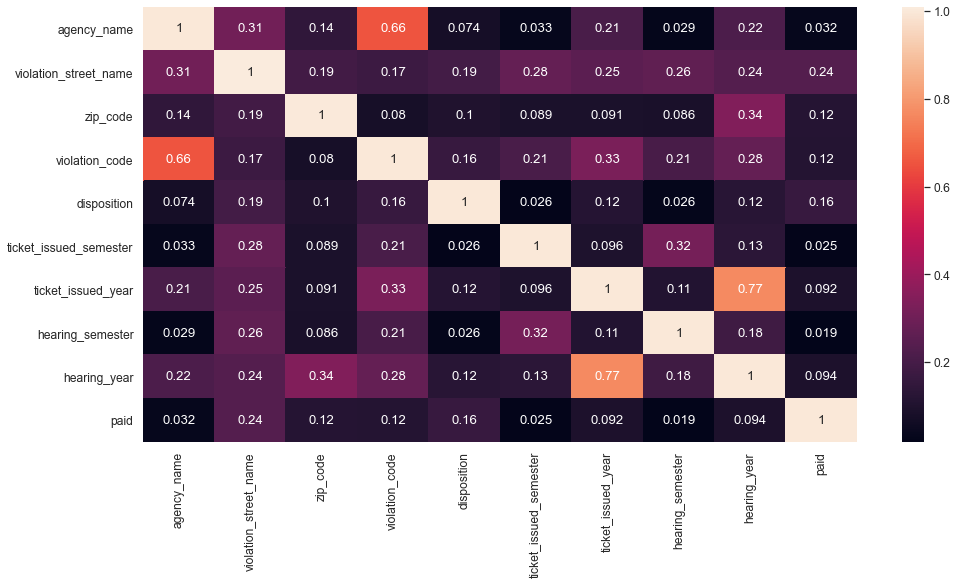

In [87]:
cate_cols = ['agency_name', 'violation_street_name', 'zip_code', 'violation_code', 'disposition', 'ticket_issued_semester', 
             'ticket_issued_year', 'hearing_semester', 'hearing_year', 'paid']
df_pay2 = df_pay.copy()
df_pay2[cate_cols] = df_pay2[cate_cols].astype('object')

cramer_matrix = {}

for column in cate_cols:
    cramer_column = []
    
    for column2 in cate_cols:
        cramer_column.append(cramer_v(df_pay2[column], df_pay2[column2]))
        
    cramer_matrix[column] = cramer_column

df_results = pd.DataFrame(cramer_matrix)
df_results = df_results.set_index(df_results.columns)

sns.heatmap(df_results, annot=True)

Through the hypotheses and the the correlation matrices, we manually selected the following features

In [88]:
manual_features = ['owed_amount', 'discount_amount', 'disposition', 'violation_street_name', 
                   'ticket_issued_year','hearing_year']

### 7.2.2 Boruta Selection

In [89]:
df_pay_scale

,agency_name,violation_street_name,mailing_address_str_name,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_status,compliance_detail,owed_amount,owed_amount_band,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_year,hearing_month,hearing_semester,paid
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,
18735,0,1070,4291,63,130,1,-3.0,20.0,10.0,-1.000000,0.0,0.0,-3.0,0.0,-0.75,0,2,-3.0,5,0,5,1,0,1,1,0
18733,0,1070,4291,63,130,1,-3.0,20.0,10.0,-1.000000,0.0,0.0,-3.0,0.0,-0.75,0,2,-3.0,5,0,5,1,0,1,1,0
28204,0,1329,2005,65,42,1,10.0,20.0,10.0,3.333333,0.0,0.0,10.0,0.0,2.50,0,2,10.0,5,0,6,2,0,4,1,0
18743,0,1474,6127,65,42,1,10.0,20.0,10.0,3.333333,0.0,0.0,10.0,0.0,2.50,0,2,10.0,5,0,6,2,0,1,1,0
18741,0,1311,5818,65,42,1,10.0,20.0,10.0,3.333333,0.0,0.0,10.0,0.0,2.50,0,2,10.0,5,0,7,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285036,1,1583,6967,91,125,1,-4.0,20.0,10.0,-1.333333,0.0,0.0,-4.0,0.0,-1.00,0,2,-4.0,5,7,11,2,7,0,1,0
285037,1,1583,6966,86,159,1,-3.0,20.0,10.0,-1.000000,0.0,0.0,-3.0,0.0,-0.75,0,2,-3.0,5,7,11,2,7,0,1,0
285034,1,1583,6966,40,0,1,5.0,20.0,10.0,1.666667,0.0,0.0,5.0,0.0,1.25,0,2,5.0,5,7,11,2,7,0,1,0


In [90]:
# training dataset for boruta
x_train = df_pay_scale.drop('paid', axis=1).values
y_train = df_pay_scale.paid.values.ravel()

rf = RandomForestClassifier(n_jobs=-1)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	6


In [91]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = df_pay_scale.drop('paid', axis=1).iloc[:, cols_selected].columns.to_list()

In [92]:
cols_selected_boruta

['agency_name',
 'violation_street_name',
 'mailing_address_str_name',
 'violation_code',
 'violation_description',
 'disposition',
 'fine_amount',
 'late_fee',
 'discount_amount',
 'judgment_amount',
 'payment_amount',
 'balance_due',
 'payment_status',
 'compliance_detail',
 'owed_amount',
 'ticket_issued_year',
 'ticket_issued_month',
 'hearing_year',
 'hearing_month']

### 7.2.3 Final Selection

In [93]:
cols_both = list(np.intersect1d(manual_features, cols_selected_boruta))
cols_both

['discount_amount',
 'disposition',
 'hearing_year',
 'owed_amount',
 'ticket_issued_year',
 'violation_street_name']

In [94]:
cols_selected_manual_not_boruta = list(np.setdiff1d(manual_features, cols_selected_boruta))
cols_selected_manual_not_boruta

[]

In [95]:
cols_selected_boruta_not_manual = list(np.setdiff1d(cols_selected_boruta, manual_features))
cols_selected_boruta_not_manual

['agency_name',
 'balance_due',
 'compliance_detail',
 'fine_amount',
 'hearing_month',
 'judgment_amount',
 'late_fee',
 'mailing_address_str_name',
 'payment_amount',
 'payment_status',
 'ticket_issued_month',
 'violation_code',
 'violation_description']

In [96]:
final_columns = cols_both + ['payment_amount', 'agency_name', 'balance_due']
final_columns

['discount_amount',
 'disposition',
 'hearing_year',
 'owed_amount',
 'ticket_issued_year',
 'violation_street_name',
 'payment_amount',
 'agency_name',
 'balance_due']

## 7.3 Models <a class='anchor' id='7.3'></a>

In [99]:
models = dict()
models['logistic_regression'] = LogisticRegression(random_state=42, max_iter=1000)
models['linear_svc'] = LinearSVC(random_state=42)
models['decision_tree'] = DecisionTreeClassifier(random_state=42)
models['random_forest'] = RandomForestClassifier(random_state=42) 
models['knn'] = KNeighborsClassifier(n_neighbors=3)
models['naive_bayes'] = GaussianNB()

In [100]:
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

In [111]:
def classification_report_with_roc_auc_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return roc_auc_score(y_true, y_pred)

In [101]:
def paid_model(df, model, columns=['owed_amount'], cross_val=False):    
    # Prepare the datasets
    X = df[columns]
    y = df['paid']

    if cross_val == False:
        # Calculate the roc_auc_score
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:,1]

        auc_score = roc_auc_score(y_test, y_pred)
    else:
        clf = model
        auc_score = np.mean(cross_val_score(clf, X, y, scoring='roc_auc', cv=3))
        
    return auc_score

In [112]:
for name, model in models.items():
    # Start counting time
    start = time.perf_counter()

    X = df_pay_scale[final_columns]
    y = df_pay_scale['paid']
    originalclass = []
    predictedclass = []
    
    #paid_score = paid_model(df_pay_scale, model, columns=final_columns, cross_val=True)
    acc = np.mean(cross_val_score(model, X, y, scoring=make_scorer(classification_report_with_roc_auc_score),cv=3))
    print('{}: {:.2%} roc auc\n'.format(name, acc))
    print(classification_report(originalclass, predictedclass, zero_division = 0))
    

    # Compute time for executing each algo
    run = time.perf_counter() - start
    print('Computational runtime of {} algorithm: {:.2f} seconds'.format(name, run))
    #print('{} model AUC score: {:.2f}\n'.format(name, paid_score))
    print('-='*30)
    print('\n')

logistic_regression: 89.57% roc auc

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     79062
           1       0.80      0.82      0.81     10943

    accuracy                           0.95     90005
   macro avg       0.89      0.90      0.89     90005
weighted avg       0.95      0.95      0.95     90005

Computational runtime of logistic_regression algorithm: 1.98 seconds
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=




C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


linear_svc: 71.95% roc auc

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     79062
           1       0.82      0.45      0.58     10943

    accuracy                           0.92     90005
   macro avg       0.87      0.72      0.77     90005
weighted avg       0.92      0.92      0.91     90005

Computational runtime of linear_svc algorithm: 8.97 seconds
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


decision_tree: 98.84% roc auc

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     79062
           1       0.95      0.98      0.96     10943

    accuracy                           0.99     90005
   macro avg       0.97      0.99      0.98     90005
weighted avg       0.99      0.99      0.99     90005

Computational runtime of decision_tree algorithm: 0.26 seconds
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


random_forest: 99.07% roc auc

       

Let's use the logistic regression algorithm, since the other models that showed better results, seems to be overfitting

## 7.4 Save Model <a class='anchor' id='7.4'></a>

In [130]:
# Prepare the datasets
X = df_pay_scale[final_columns]
y = df_pay_scale['paid'] 

X_train, X_test, y_train, y_test = train_test_split(X, y)

lr_paid = LogisticRegression(max_iter=1000)
lr_paid.fit(X, y)

#jb.dump(rf,"model/rf_paid.pk;.z")

LogisticRegression(max_iter=1000)

In [131]:
df_check = df_pay.copy()
df_check['prediction'] = pd.Series(lr_paid.predict_proba(X)[:,1]).values
df_check[(df_check['payment_status'] != 'PAID IN FULL') & (df_check['balance_due'] > 0)].sort_values(by='prediction', ascending=False)

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,compliance_detail,owed_amount,owed_amount_band,ticket_issued_year,ticket_issued_month,ticket_issued_semester,hearing_year,hearing_month,hearing_semester,payment_year,payment_month,paid,prediction
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26217,Detroit Police Department,"Loftis, Gary","STANLEY, RAYMOND E.",9231.0,CHAMBERLAIN,9231.0,CHAMBERLAIN,Detroit,MI,48209,USA,2005-03-23 14:00:00,2005-03-31 09:00:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Admission,2500.0,20.0,10.0,0.0,0.0,0.0,2530.0,2280.0,250.0,2005-03-31 00:00:00,PARTIAL PAYMENT APPLIED,non-compliant by no payment,2530.0,4,2005,03,1,2005,03,1,2005,03,0,1.000000e+00
141234,Department of Public Works,"Hayes, Billy J","FRANKS, JOHN W",15109.0,SCHAEFER,185.0,STANSBURY,Detroit,MI,48235,USA,2007-10-09 08:45:00,2007-11-15 10:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Admission,3500.0,20.0,10.0,0.0,0.0,0.0,3530.0,3180.0,350.0,2007-11-15 00:00:00,PARTIAL PAYMENT APPLIED,non-compliant by no payment,3530.0,4,2007,10,2,2007,11,2,2007,11,0,1.000000e+00
218882,Department of Public Works,"McClain, Melvin","MOSS, PRUE",15745.0,ASBURY PARK,15769.0,ASBURY PARK,Detroit,MI,48227,USA,2009-05-14 14:30:00,2009-06-02 10:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Admission,2500.0,20.0,10.0,0.0,0.0,0.0,2530.0,2500.0,30.0,2009-06-02 00:00:00,PARTIAL PAYMENT APPLIED,non-compliant by no payment,2530.0,4,2009,05,1,2009,06,1,2009,06,0,1.000000e+00
99932,Department of Public Works,"Cato, Valesta","PALEN, MILDRED R",19407.0,WARREN,6547.0,WARWICK,Detroit,MI,48228,USA,2006-11-03 12:00:00,2006-11-20 10:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Admission,3500.0,20.0,10.0,0.0,0.0,0.0,3530.0,3180.0,350.0,2006-11-20 00:00:00,PARTIAL PAYMENT APPLIED,non-compliant by no payment,3530.0,4,2006,11,2,2006,11,2,2006,11,0,1.000000e+00
218060,Department of Public Works,"Williamson, Lillett","HAMILTON, WENDY J",4366.0,BEACONSFIELD,476.0,AUDUBON,Detroit,MI,48224,USA,2009-05-12 10:00:00,2009-06-05 15:00:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Admission,2500.0,20.0,10.0,0.0,0.0,0.0,2530.0,1641.3,888.8,2012-02-07 00:00:00,PARTIAL PAYMENT APPLIED,non-compliant by no payment,2530.0,4,2009,05,1,2009,06,1,2012,02,0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135781,Department of Public Works,"Zizi, Josue","McCASKILL, DELVA",12047.0,SUSSEX,547.0,E KIRBY APT 301,Detroit,MI,48202,USA,2007-09-10 11:15:00,2007-11-27 09:00:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Default,10000.0,20.0,10.0,1000.0,0.0,0.0,11030.0,0.0,11030.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,11030.0,4,2007,09,2,2007,11,2,NaN,NaN,0,3.072464e-32
112219,Department of Public Works,"Hayes, Billy J","MILES, DIANNE YVONNE",12960.0,WINTHROP,1296.0,WINTHROP,Detroit,MI,48227,USA,2007-02-19 09:40:00,2007-03-08 10:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Default,10000.0,20.0,10.0,1000.0,0.0,0.0,11030.0,0.0,11030.0,NaN,NO PAYMENT APPLIED,non-compliant by no payment,11030.0,4,2007,02,1,2007,03,1,NaN,NaN,0,3.033225e-32
92968,Department of Public Works,"McClain, Melvin","ARRINGTON, DUNK",4055.0,JOY RD,455.0,JOY RD,Detroit,MI,48204,USA,2006-09-20 12:00:00,2006-10-12 10:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Default,10000.0,20.0,10.0,1000.0,0.0,0.

# 8. Prediction <a class='anchor' id='8.'></a>

In [3]:
df_test = pd.read_csv('csv/test.csv', encoding='ISO-8859-1', low_memory=False)
df_test.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [6]:
df_test.describe()

,ï»¿X,Y,ticket_id,violation_street_number,violator_id,clean_up_cost,payment_amount,oid,geom,fine_amount
count,492030.000000,492030.000000,522060.000000,5.220600e+05,522060.000000,0.0,0.0,522060.000000,0.0,0.0
mean,-83.110666,42.390790,294885.677236,1.335216e+04,264637.654492,NaN,NaN,294885.677236,NaN,NaN
std,0.098564,0.036842,157929.603915,1.419025e+06,153949.576061,NaN,NaN,157929.603915,NaN,NaN
min,-83.287465,42.255756,18645.000000,-1.512600e+04,1.000000,NaN,NaN,18645.000000,NaN,NaN
25%,-83.192738,42.365350,158363.750000,5.016000e+03,131164.750000,NaN,NaN,158363.750000,NaN,NaN
50%,-83.127147,42.396165,296650.500000,1.082100e+04,263437.500000,NaN,NaN,296650.500000,NaN,NaN
75%,-83.027584,42.420337,430768.500000,1.621500e+04,397224.500000,NaN,NaN,430768.500000,NaN,NaN
max,-82.911179,42.450014,567384.000000,1.000000e+09,533833.000000,NaN,NaN,567384.000000,NaN,NaN


In [ ]:
null_features = df_test.isnull().sum()
all_null = df_test.columns[list(null_features == df_test.shape[0])]
df_test.drop(all_null, axis=1, inplace=True)

In [ ]:
null_features = df_test.isnull().sum()
null_2000 = df_test.columns[list((null_features < 2000) & (null_features != 0))]
df_test.drop(df_test[df_test[null_2000].isnull().any(axis=1)].index, inplace=True)

In [ ]:
df_test['owed_amount'] = df_test['judgment_amount'] - df_test['discount_amount']
df_test = pd.concat([df_test, df_test['ticket_issued_date'].str.extract(r'(?P<ticket_issued_year>\d{4})-(?P<ticket_issued_month>\d{2})')], axis=1)
df_test['ticket_issued_semester'] = [1 if x <= 6 else 2 for x in df_test['ticket_issued_month'].astype(int)]
df_test = pd.concat([df_test, df_test['hearing_date'].str.extract(r'(?P<hearing_year>\d{4})-(?P<hearing_month>\d{2})')], axis=1)
df_test['hearing_semester'] = [1 if x <= 6 else 2 for x in df_test['hearing_month'].astype(int)]
df_test.head()

In [ ]:
df_pred = df_test.copy()
df_pred = df_pred[final_columns]
df_pred.head()